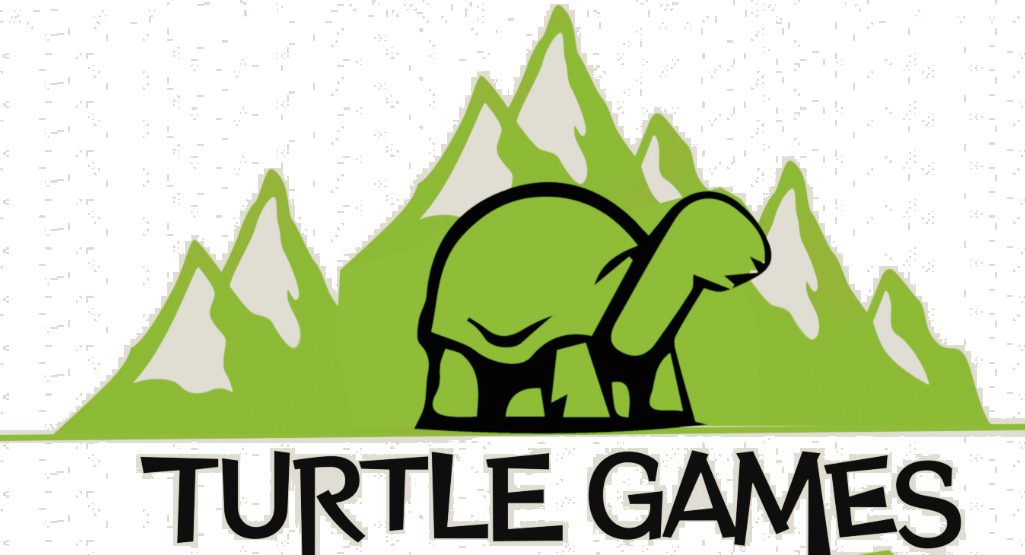

<div style="background-color:#4E8A57; color:white; padding:20px; text-align:center; font-weight:bold; border-radius: 8px; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);">

<h2 style="font-size: 24px;"> Predicting future outcomes</h2>
    
</div>


#  Advanced Analytics for Organisational Impact

### Scenario
We have been engaged by Turtle Games, a global game manufacturer and retailer that produces and sells its own products, as well as sources and sells products manufactured by other companies. Their product range includes books, board games, video games, and toys. This analysis will utilize customer review data (turtle_review.csv) to provide insights into various key strategic objectives with the ultimate aim of improving overall sales performance, customer retention and marketing approach.

In particular, this notebook will focus on the following objectives defined by Turtle Games: 
- Determine how customers accumulate loyalty points 
- Exploring the structure of data using decision trees 
- Exploring clusters in customer behaviour 
- Determine if can social data (e.g. customer reviews) be used in marketing campaigns.

Further statistical analysis and modelling will be instead performed in R consistent with the historical preferences and established workflow of the sales department in utilizing this tool. In R, we will evaluate the current performance of the loyalty points system and assess wheather the data can effectively support predictive modelling



**Analytical Approach**

1) **Business Problem Definition.**

2) **Data ingestion and Wrangling.**
Involved: cleaning for missing values, handling duplicates, and transforming data to ensure it was suitable for statistical modeling and machine learning.

3) **Analysis of variables influencing loyalty points accumulation.**
We performed linear regression to compute the influence of income and spending score change in loyalty points. MLR model was able to explain high variation of loyalty points, however heteroskedasticy and non linear patterns in distribution of residuals, confirmed poor fit and presence of underlying factors that the MLR was not able to capture. 

4) **Analysis of Feature importance with Decision Tree to handle non linearity.** 
Employing a Decision tree regressor allowed us to handle the non linearity observed and to better understand the structure found in the data, including, with feature importance ananlysis different categorical variables that could explain how customer engage with loyalty points. 

5) **Clustering with K-Means.**
Given the importance of income and spending score identified in previous analyses, K-Means clustering was performed to segment customers based on these attributes. This clustering analysis provides actionable insights into different customer segments, guiding targeted marketing efforts and personalized strategies for maximizing loyalty program effectiveness.

6) **Analysis of Sentiments:** to gauge opinions and customer satisfaction towards Turtle Games products


### 1. DATA EXPLORATION AND INGESTION

**Load and explore the data**

In [83]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# Regression Analysis 
import statsmodels.api as sm 
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from sklearn import metrics
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#Decision Tree Regressor 
from sklearn.tree import DecisionTreeRegressor, plot_tree 
# CrossValidation with K Fold
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

# Cluster Analysis 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist


# Sentiment Analysis 
import contractions  # !pip install contractions 
import re
import nltk
from nltk import word_tokenize, pos_tag
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
#!pip install spellchecker
#!pip install pyspellchecker
from spellchecker import SpellChecker 
from wordcloud import WordCloud
from nltk.probability import FreqDist
from scipy.stats import norm
import pandas as pd

# Load SpaCy model
!python -m spacy download en_core_web_sm
!pip install spaCy
from spacy.matcher import Matcher
nlp = spacy.load("en_core_web_sm")
import spacy

# Import Counter.
from collections import Counter

# Download necessary NLTK data files
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

import warnings


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 487.6 kB/s eta 0:00:27
      --------------------------------------- 0.3/12.8 MB 2.8 MB/s eta 0:00:05
     -- ------------------------------------- 0.7/12.8 MB 4.3 MB/s eta 0:00:03
     --- ------------------------------------ 1.1/12.8 MB 5.3 MB/s eta 0:00:03
     ---- ----------------------------------- 1.5/12.8 MB 6.1 MB/s eta 0:00:02
     ------ --------------------------------- 1.9/12.8 MB 6.5 MB/s eta 0:00:02
     ------- -------------------------------- 2.3/12.8 MB 7.0 MB/s eta 0:00:02
     ------- -------------------------------- 2.5/12.8 MB 6.3 MB/s eta 0:00:02
     -------- ------------------------------- 2.6/12.8 MB 5.9 MB/s eta 0:00:02
     --------- ------------------------------ 2.9/12.8 MB 5.9 MB/s eta 0:00:02
     ---------- ----------------------------- 3.3/12.8 MB 6.3 MB/

NameError: name 'spacy' is not defined

In [32]:
# User functions

def validate_data(df):
    #check for unique values
    unique_counts = df.nunique()
    print("Unique values per column:")
    print(unique_counts)
    
    #checking for duplicates
    duplicate_count = df.duplicated().sum()
    print("\nNumber of duplicate rows:")
    print(duplicate_count)
    
    #summary stats
    summary_stats = df.describe()
    print("\nSummary statistics:")
    print(summary_stats)
    

def ingest_data(df):
    print('DataFrame shape:', df.shape)
    
    # Print the data types of each column
    data_types = df.dtypes
    print('\nData types:')
    print(data_types)
    
    # Print the number of missing values in each column
    missing_values = df.isna().sum()
    print('\nNumber of missing values:')
    print(missing_values)
    

def max_abs_scaling(df):
    '''this function apply max and abs methods to df or series to scale the dataset'''
    # Copy the DataFrame.
    df_scaled = df.copy()
    # if input is df
    if isinstance(df_scaled, pd.DataFrame):
        # Apply maximum absolute scaling.
        for column in df_scaled.columns:
            df_scaled[column] = df_scaled[column] / df_scaled[column].abs(
            ).max()
    else:
        # If the input is not a df, scale the series
        df_scaled = df_scaled / df_scaled.abs().max()
        
    return df_scaled


def variable_count(df,x):
    print('Record Count: ')
    value_counts = df[x].value_counts().reset_index()
    print(value_counts)
    

def apply_K_Means_plot(df, k_value, x_col, y_col,random_state = 42): 
    ''' this function applies the K-Means algorithm on the provided DataFrame, creates a scatterplot of specified columns with cluster split,
    and returns the predicted cluster array.
    '''
    # Fit the K-Means model
    km = KMeans(n_clusters=k_value, n_init=10, init = 'k-means++', random_state=42)
    km.fit(df)
    
    # Predict clusters
    clusters = km.predict(df)
   
    # Append predicted clusters to the DataFrame
    df.loc[:, 'label'] = clusters
    
    # Plot the clusters with scatterplot
    plt.figure(figsize=(8, 4))
    palette = sns.color_palette('Set2', k_value)
    sns.scatterplot(x=x_col, y=y_col, hue='label', data=df, palette=palette)
    
    # Set title and labels
    plt.title(f'Clusters with K={k_value}, \n {x_col} Vs {y_col}')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    
    # Show the plot
    plt.show()
    return clusters   
    
    

def clean_text(text):
    '''User-defined function to clean text by removing links, RT, punctuation and special characters. It
    splits the text into tokens, removes stopwords (excluding 'not'), and lemmatises the tokens
    with the correct Part Of Speech tags.'''
    # Expand contractions
    text = contractions.fix(text)
    # Convert to lower case
    text = text.lower()
    # Remove links
    text = re.sub(r"https\S+|www\S+https\S+", '', text, flags=re.MULTILINE)
    # Remove hashtags, retweets, and mentions
    text = re.sub(r'@\w+|\#|rt', '', text)
    # Remove special characters
    text = re.sub(r'\W', ' ', text)
    # Split the text into tokens
    text_tokens = word_tokenize(text)
    # Remove stopwords from updated list 
    filtered_tokens = [w for w in text_tokens if not w in stop_words_update]
    # Lemmatize the tokens with correct POS tags
    lemmatized_tokens = [lemma_function.lemmatize(token, tag_map[tag[0]]) for token, tag in pos_tag(filtered_tokens)]
    # Join the lemmatized tokens back into a single string
    return " ".join(lemmatized_tokens)



def group1_apply_operation(df, x, y, operation):
    '''
    This function groups by one specified variable (x) and applies a specified operation on column y
    '''
    grouped_df = df.groupby(x)[y].apply(operation).reset_index()
    return grouped_df


In [33]:
# Load the CSV file(s) as reviews.
reviews= pd.read_csv('turtle_reviews.csv')

#Validate Reviews dataset using user function
print(validate_data(reviews))

# Ingest the data using user function
print(ingest_data(reviews))

Unique values per column:
gender                       2
age                         45
remuneration (k£)           64
spending_score (1-100)      84
loyalty_points             627
education                    5
language                     1
platform                     1
product                    200
review                    1980
summary                   1432
dtype: int64

Number of duplicate rows:
0

Summary statistics:
               age  remuneration (k£)  spending_score (1-100)  loyalty_points  \
count  2000.000000        2000.000000             2000.000000     2000.000000   
mean     39.495000          48.079060               50.000000     1578.032000   
std      13.573212          23.123984               26.094702     1283.239705   
min      17.000000          12.300000                1.000000       25.000000   
25%      29.000000          30.340000               32.000000      772.000000   
50%      38.000000          47.150000               50.000000     1276.000000   
75%

Average customer age who reviewed the products is 40 yo, with a relative high income.

Loyalty points: present high variations, with 25% of data(customers) with 772 or fewer loyalty points and 50% of customers with 1276 or fewer loyalty points.  This also suggest the presence of segments based on loyalty points and hence may indicate the need to develop different strategies related to customer retention, marketing segementatioin and loyalty programs. 

**Drop, rename and tranform columns for better readibility**

In [34]:
# Drop unnecessary columns.
reviews2 = reviews.drop(['language','platform'],axis=1)

# Rename columns headers for better reference and usability
reviews2.rename(columns={'remuneration (k£)': 'income','spending_score (1-100)': 'spending_score'},inplace=True)

# View amended columns
reviews2.columns

Index(['gender', 'age', 'income', 'spending_score', 'loyalty_points',
       'education', 'product', 'review', 'summary'],
      dtype='object')

Reviews dataset does not have duplicates and missing values and is ready to be fed for machine learning.

**Save the DataFrame as a CSV file**

In [35]:
# Create a CSV file as output.
reviews2.to_csv('turtle_reviews_final_csv',index=False)

# Import new CSV file with Pandas.
reviews_final= pd.read_csv('turtle_reviews_final_csv')

# View DataFrame.
reviews_final.head()

gender  age  income  spending_score  loyalty_points education  product  \
0    Male   18   12.30              39             210  graduate      453   
1    Male   23   12.30              81             524  graduate      466   
2  Female   22   13.12               6              40  graduate      254   
3  Female   25   13.12              77             562  graduate      263   
4  Female   33   13.94              40             366  graduate      291   

                                              review  \
0  When it comes to a DM's screen, the space on t...   
1  An Open Letter to GaleForce9*:\n\nYour unpaint...   
2  Nice art, nice printing.  Why two panels are f...   
3  Amazing buy! Bought it as a gift for our new d...   
4  As my review of GF9's previous screens these w...   

                                             summary  
0  The fact that 50% of this space is wasted on a...  
1  Another worthless Dungeon Master's screen from...  
2                    pretty, but also pretty useless  
3                                         Five Stars  
4                                         Money trap

## EDA: Exploratory Data Analysis 

In [36]:
# Create subset with variables of interests 
reviews_sub = reviews_final[['age','income','spending_score','loyalty_points']]

**Visualise the Data** 

Text(0.5, 1.0, 'Loyalty Points Distribution')

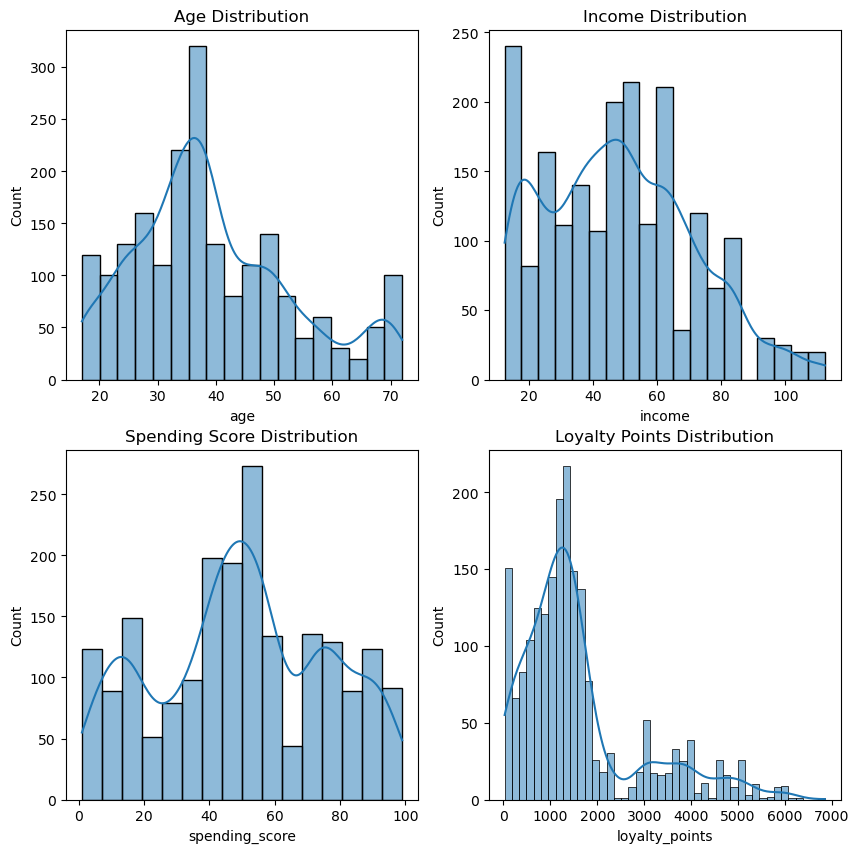

In [37]:
# Check distribution 
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

sns.histplot(data= reviews_sub, x='age', kde=True, ax=ax1)
ax1.set_title('Age Distribution')

sns.histplot(data=reviews_sub, x='income', kde=True, ax=ax2)
ax2.set_title('Income Distribution')

sns.histplot(data=reviews_sub, x='spending_score', kde=True, ax=ax3)
ax3.set_title('Spending Score Distribution')

sns.histplot(data=reviews_sub, x='loyalty_points', kde=True, ax=ax4)
ax4.set_title('Loyalty Points Distribution')


-Age: appears approximately bell-shaped, indicating a somewhat normal distribution with a higher skew toward young ages. Majority of customers who left reviews are between 30-40 years old.

-Income: right positive skew. Different income groups, average of high earners but high frequencies of low incomes too.

-Spending score: multiple peaks indicating a multimodal distribution and different spending behaviours.

Loyalty points: The distribution is heavily right-skewed, with a long tail towards higher values.A square root transformation might be beneficial here to normalise the data as it would 'compress' more high values.

**The majority of customers have accrued between 0 and 1500 loyalty points, suggesting good opportunities to increase engagement with many (high frequencies especially for low loyalty points)**

<function matplotlib.pyplot.show(close=None, block=None)>

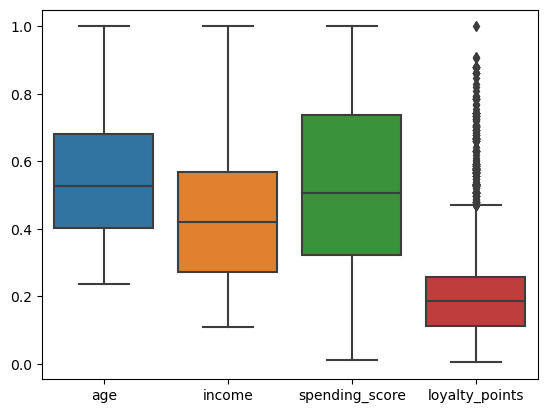

In [38]:
# Check outliers with boxplot on scaled data,using max_abs_scaling function 
sns.boxplot(data = max_abs_scaling(reviews_sub))

#View output
plt.show

Loyalty points present several outliers on the upper whisker, suggesting that some customers have significantly higher loyalty points compared to others (right skewed distribution)

This is what we would expect for our target variables. Given the objective is to understand factor contributing to this variation outliers won't be removed.

**More detailed exploratory analysis will follow in R.Analysis, observations and insight will be documented in the EDA section of the technical report.**

## Quick Diagnostic Analysis 

Are there differences in spending scores, income and loyalty points that could be explained by Gender or Education gaps?

In [39]:
spending_score_by_gender = group1_apply_operation(reviews_final, 'gender', 'spending_score', pd.Series.mean)
spending_score_by_gender

gender  spending_score
0  Female       50.691071
1    Male       49.120455

In [40]:
spending_score_by_education_gender = reviews_final.groupby(['education','gender'])['spending_score'].mean()
spending_score_by_education_gender.reset_index()

education  gender  spending_score
0         Basic  Female       57.750000
1         Basic    Male       50.266667
2           PhD  Female       46.254545
3           PhD    Male       46.966667
4       diploma  Female       38.900000
5       diploma    Male       43.862500
6      graduate  Female       53.903774
7      graduate    Male       52.002703
8  postgraduate  Female       52.479167
9  postgraduate    Male       48.100000

In [41]:
spending_score_by_education = group1_apply_operation(reviews_final, 'education', 'spending_score', pd.Series.mean)
spending_score_by_education

education  spending_score
0         Basic       53.260000
1           PhD       46.626087
2       diploma       40.989474
3      graduate       53.122222
4  postgraduate       50.727500

In [42]:
income_by_gender = group1_apply_operation(reviews_final, 'gender', 'income', pd.Series.mean)
income_by_gender

gender     income
0  Female  47.291304
1    Male  49.081659

In [43]:
income_by_education = group1_apply_operation(reviews_final, 'education', 'income', pd.Series.mean)
income_by_education

education     income
0         Basic  59.581200
1           PhD  51.225043
2       diploma  43.585158
3      graduate  47.302156
4  postgraduate  46.906050

In [44]:
loyalty_by_gender= group1_apply_operation(reviews_final, 'gender', 'loyalty_points', pd.Series.mean)
loyalty_by_gender

gender  loyalty_points
0  Female     1601.166964
1    Male     1548.587500

In [45]:
loyalty_by_education= group1_apply_operation(reviews_final, 'education', 'loyalty_points', pd.Series.mean)
loyalty_by_education

education  loyalty_points
0         Basic     2265.040000
1           PhD     1499.750000
2       diploma     1336.021053
3      graduate     1666.057778
4  postgraduate     1499.077500

Key points: 

- On average there are not striking differences in spending score by gender, whilst female customers with Basic, Graduate and Postgraduate education tend to spend more. 

- These differences in spending score appear not be explained by disposable income.

On the contrary, females on average accumulate more loyalty points than males, which could suggest a higher engagement or a preference for loyalty programs among female customers.    

**to explore**

## Objective 1. How customers accumulate loyalty points?

### Analysis of age, income and spending scores as factors contributing to loyalty behaviours with Regression.

In [46]:
# Create subset with variables of interests 
reviews_sub = reviews_final[['age','income','spending_score','loyalty_points']]

In [47]:
# Check correlations between spending scores, income, age with loyalty 
reviews_sub.corr()

age    income  spending_score  loyalty_points
age             1.000000 -0.005708       -0.224334       -0.042445
income         -0.005708  1.000000        0.005612        0.616065
spending_score -0.224334  0.005612        1.000000        0.672310
loyalty_points -0.042445  0.616065        0.672310        1.000000

- Strong positive correlation spending score and loyalty behaviours (r = 0.672).
- Strong positive correlation income and loyalty  (r = 0.616)
- Very low negative correlation between age and loyalty behaviours (r= - 0.04)

Next, we will check this unique relationship more closely with linear regression models with OLS. The objective is to understand how much these feature variables influence loyalty behaviours.

C:\Users\rossi\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


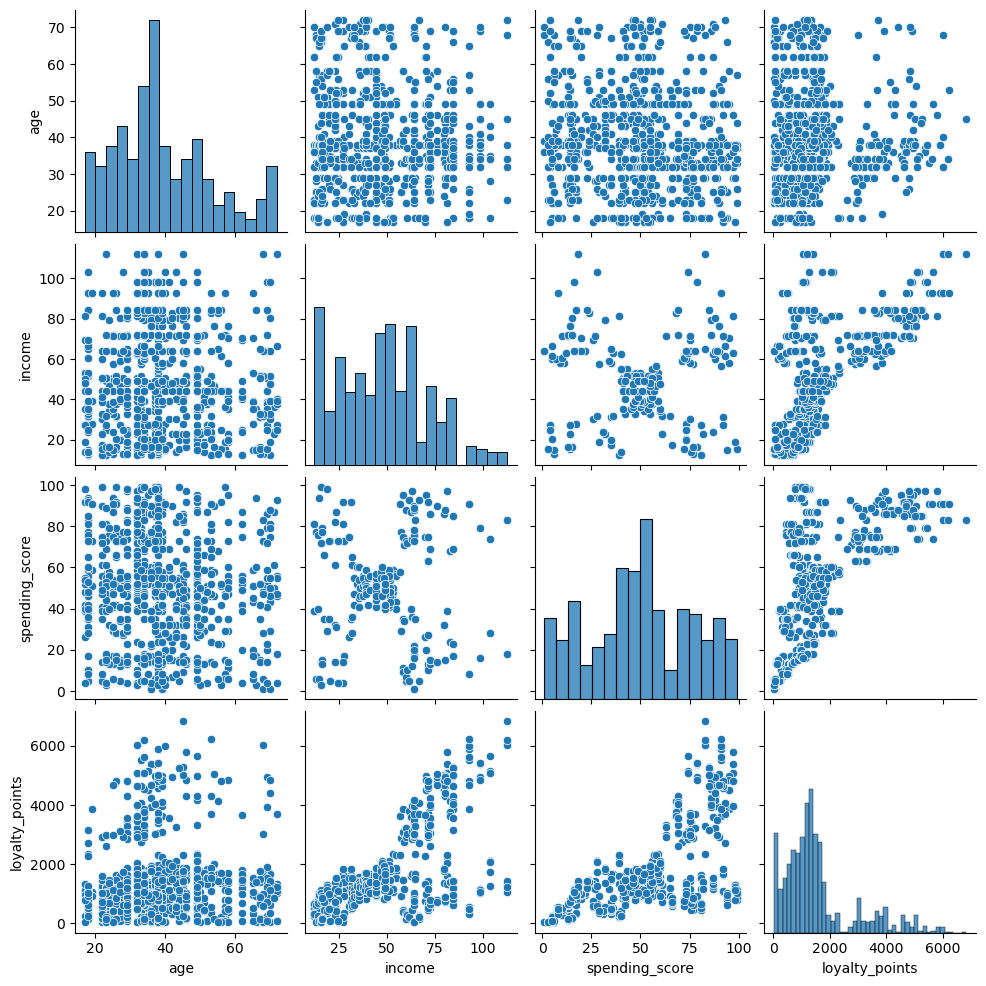

In [48]:
# Create pairplot for techical report. 
sns.pairplot(data=reviews_sub)

**Visualise and Explore the Relationships**

## Spending vs Loyalty

Text(0.5, 1.0, 'Spending Score Vs Loyalty Points Scatterplot')

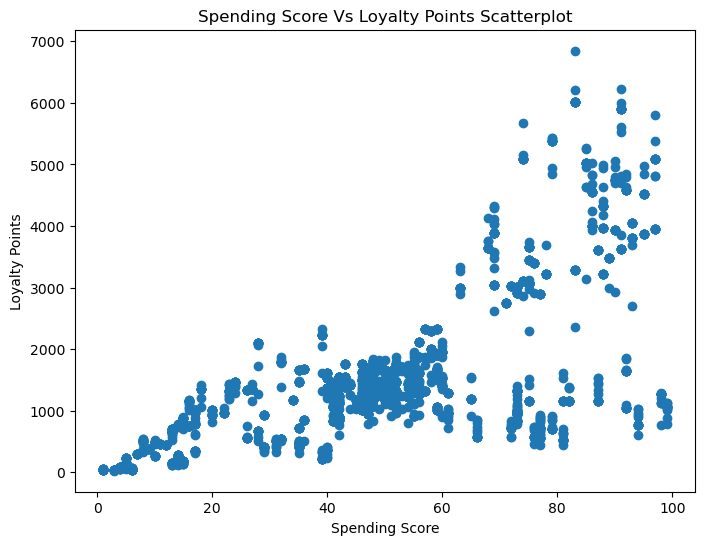

In [49]:
# Define independent variable.
x= reviews_sub['spending_score']

# Define dependent variable.
y= reviews_sub['loyalty_points']

#Check for linearity with scatterplot
plt.figure(figsize= (8,6))
plt.scatter(x,y)
plt.xlabel('Spending Score')
plt.ylabel('Loyalty Points')
plt.title('Spending Score Vs Loyalty Points Scatterplot')


Overall there is some linear relationship. Generally as spending score increase so does loyalty point, but this more true for those customers with spending score <= 60. 

Higher spendings score appear not being correlated with high loyalty points, suggesting that for some customers with high spending behaviours alternative engagement strategies might be needed since they are not maximising point accumulation. We need to further investigate the reasons but factors could include: 

- large infrequent purchases 
- items purchased migth not be eligible to loyalty points 
- customers that are not successfully engaged/ partecipate. 

**Create a Linear Regression Model to better evaluate this relationship.**

In [50]:
#add constant to the regression line
x_const = sm.add_constant(x)

# Fit the model
lr = sm.OLS(y, x_const).fit()

# Summary of Regression results 
print(lr.summary())


                            OLS Regression Results                            
Dep. Variable:         loyalty_points   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     1648.
Date:                Mon, 09 Sep 2024   Prob (F-statistic):          2.92e-263
Time:                        16:27:55   Log-Likelihood:                -16550.
No. Observations:                2000   AIC:                         3.310e+04
Df Residuals:                    1998   BIC:                         3.312e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -75.0527     45.931     -1.

**R-squared(0.452)**: The variation in loyalty points is explained for 45,2% by the variation in spending score. This is a benchmark, but it suggests a relatively poor fit since more than half (54,8 %) of the variability in loyalty points is explained by other factors not included in the model. 

**Estimated coefficient(33.06)**: For each unit  increase in spending score on average we see an increase of 33.06 loyalty points 

**Kurtosis(4.554)**:  heavy tails, indicating outliers in the distribution of residuals. 

**P value (0.000)** Indicating that the relationship between spending score and loyalty points is highly statistically significant and not due to chance. 
We are 95% confident that the loyalty point sensitivity to spending score is within the interval 31.464 < x > 34.659



In [51]:
# Extract the estimated parameters.
print("Parameters: ", lr.params)  

# Extract the standard errors.
print("Standard errors: ", lr.bse)  

# Extract the predicted values.
print("Predicted values: ", lr.predict(x_const))  

Parameters:  const            -75.052663
spending_score    33.061693
dtype: float64
Standard errors:  const             45.930554
spending_score     0.814419
dtype: float64
Predicted values:  0       1214.353374
1       2602.944491
2        123.317497
3       2470.697718
4       1247.415067
           ...     
1995    2206.204172
1996     189.440883
1997    2933.561424
1998     453.934429
1999     189.440883
Length: 2000, dtype: float64


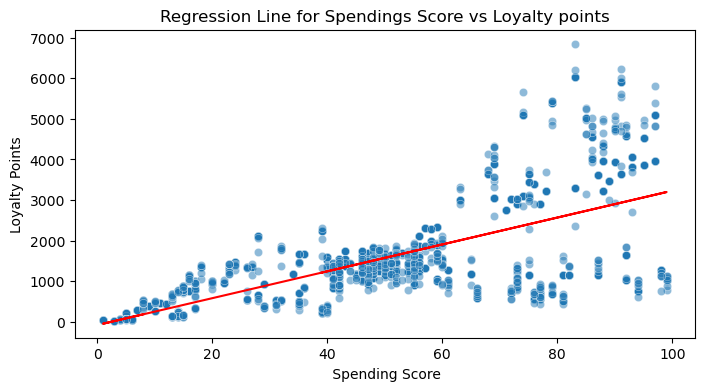

In [52]:
# Create variable to store predicted loyalty points
predictions= lr.predict(x_const)

# Set plot size 
plt.figure(figsize=(8, 4), dpi=100)

# Plot the graph with a regression line.
sns.scatterplot(data= reviews_sub, x= 'spending_score', y='loyalty_points', alpha=0.5)

# Set labels and title 
plt.title("Regression Line for Spendings Score vs Loyalty points")
plt.xlabel(" Spending Score")
plt.ylabel("Loyalty Points")

# add Regression line 
plt.plot(reviews_sub['spending_score'], predictions, color='red')

**Check Residuals to assess the goodness-of-fit of a regression model (errors)**

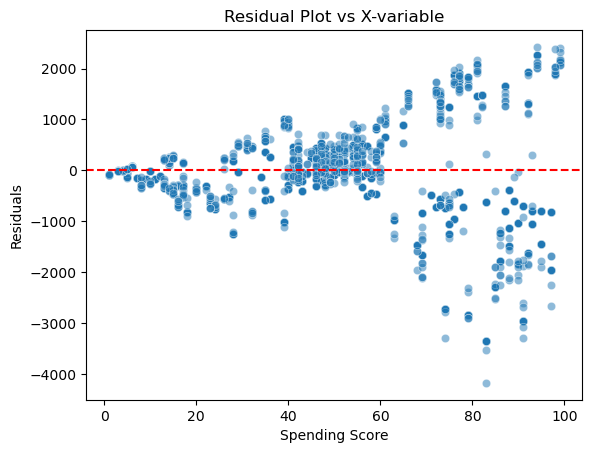

In [53]:
# Calcolate residuals
residuals= lr.predict()- y

# Set Residual Plot 
sns.scatterplot(x=x, y=residuals, alpha=0.5)

# Add the zero residual line to improve clarity
plt.axhline(y=0, color='red', linestyle='--')
# Set title and axis labels
plt.title("Residual Plot vs X-variable")
plt.xlabel("Spending Score")
plt.ylabel("Residuals")
plt.show()

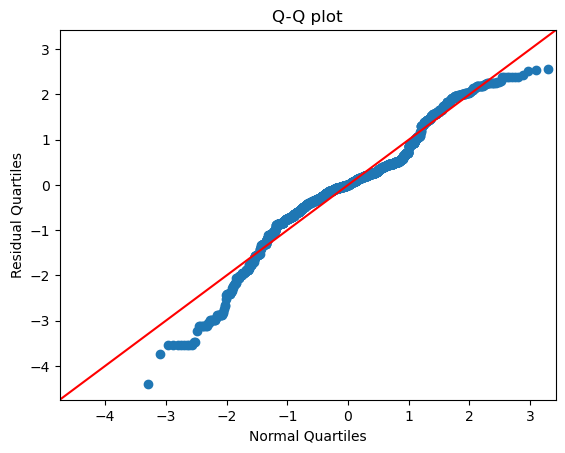

In [54]:
# check of distribution of residuals with QQ-plot
sm.qqplot(residuals, fit=True, line='45')
plt.ylabel("Residual Quartiles")
plt.xlabel("Normal Quartiles")
plt.title("Q-Q plot")
plt.show()

This shows us two important things: 

- Heteroscedasticity (cone shape distribution) variance increases with x (but not exponentially!): violates the assumption of constant variance of residuals and impacts the model's **predictive reliability** 

- The difference between predicted and actual values spread out for customers with spending scores of 60 and above, indicating that the model's predictions become less accurate for customers with higher spending scores. 

In this case, heteroscedasticity stems from the inherent characteristics and  interplay between the income-spending score-loyalty behaviour variables. Specifically, different purchasing powers and spending habits across income levels can lead to a wide variance in loyalty points, reflected in high spread between the minimum and maximum values.


**N.B: non normal Variance of Residuals do not affect coefficients which remain unbiased, but inflates standard errors (leading to prediction inaccurracy), which in turn inflate the p-values associated with each coefficient.** 

To understand the the direct impact of x/X on y we will use the original model, whilst for predictions we will address heteroskedasticity. This apporach will be followed for others linear models too. 

**To address Heteroscedasticityi in this simple linear model and improve inference and model efficiency, we will try 2 different approaches**.
1) Square root transformation of the target variable: this might adjust the variance and non linearity in the relationship.
   If trasnformation will be not sufficient, this will mean that spending score alone is not able to explain the variability of    loyalty points and further explanatory varibales should be included. 
   
2) Segmenting the data where heteroskedasticity is not present. This will also validate the findings that customers with spending scores below 60 are more related to loyalty behaviours while statistically determining whether different marketing strategies should be applied after certain spending score thresholds. 


## TEST 1:  Using Square Root Transformation to Improve Linear Regression**


                            OLS Regression Results                            
Dep. Variable:         loyalty_points   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     2200.
Date:                Mon, 09 Sep 2024   Prob (F-statistic):               0.00
Time:                        16:27:56   Log-Likelihood:                -7570.4
No. Observations:                2000   AIC:                         1.514e+04
Df Residuals:                    1998   BIC:                         1.516e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             15.1643      0.515     29.

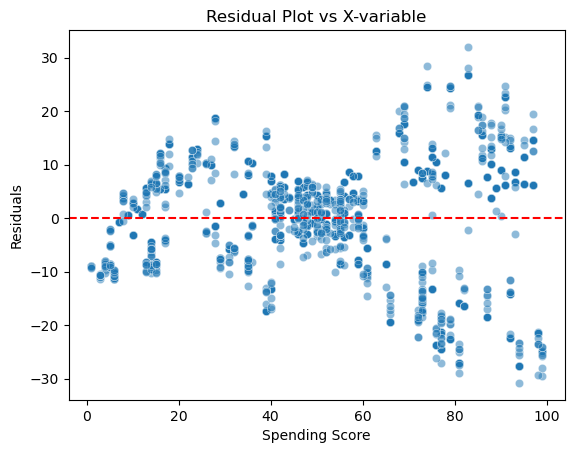

{'LM stat': 455.8631000544193, 'LM Test p-value': 3.8208579851841366e-101, 'F-stat': 589.8534475413608, 'F-test p-value': 2.188281451788302e-114}


In [55]:
# Transform loyalty points values to its square root form. 
y_sqr = np.sqrt(y)

# Fit the model with the transformed variable
lr_sqr = sm.OLS(y_sqr, x_const).fit()

# Summary of Regression results with logarithmic transformation
print(lr_sqr.summary())

# Calcolate residuals
residuals_1= lr_sqr.resid

# Set Residual Plot 
sns.scatterplot(x=x, y=residuals_1, alpha=0.5)

# Add the zero residual line to improve clarity
plt.axhline(y=0, color='red', linestyle='--')
# Set title and axis labels
plt.title("Residual Plot vs X-variable")
plt.xlabel("Spending Score")
plt.ylabel("Residuals")
plt.show()

# Run the Breusch-Pagan test function on the model residuals and x-variables.
test_sqr = sms.het_breuschpagan(lr_sqr.resid, lr_sqr.model.exog)

# Create a variable to store the outputs
terms = ['LM stat', 'LM Test p-value', 'F-stat', 'F-test p-value']
#Print the results of the Breusch-Pagan test.
print(dict(zip(terms, test_sqr)))


Although transformed, the distribution of residuals is not normal. This confirm that spending score alone cannot capture the variance in loyalty points. 

**Adding explanatory variables might better capture the true pattern of the data, improving heteroskedasticity and normality of residuals **

## Test 2: Run the model on subset data where spending score <= 60

In [56]:
# Create subset
spend_score_below60 = reviews_sub[reviews_sub['spending_score']<= 60]

#Check filtered subset 
print(spend_score_below60.describe())
print(spend_score_below60.corr())

               age       income  spending_score  loyalty_points
count  1367.000000  1367.000000     1367.000000     1367.000000
mean     42.109729    47.076518       35.811266     1071.553036
std      14.479944    20.233281       17.691750      582.362292
min      17.000000    12.300000        1.000000       25.000000
25%      33.000000    35.260000       17.000000      539.000000
50%      40.000000    44.280000       41.000000     1177.000000
75%      51.000000    58.220000       50.500000     1501.000000
max      72.000000   112.340000       60.000000     2332.000000
                     age    income  spending_score  loyalty_points
age             1.000000 -0.069678       -0.001877        0.127207
income         -0.069678  1.000000       -0.152917        0.364132
spending_score -0.001877 -0.152917        1.000000        0.775127
loyalty_points  0.127207  0.364132        0.775127        1.000000


Strong positive correlation (0.77) loyalty points and customers with spending scores below 60. 

                            OLS Regression Results                            
Dep. Variable:         loyalty_points   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     2055.
Date:                Mon, 09 Sep 2024   Prob (F-statistic):          1.74e-274
Time:                        16:27:56   Log-Likelihood:                -10015.
No. Observations:                1367   AIC:                         2.003e+04
Df Residuals:                    1365   BIC:                         2.005e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            157.8290     22.483      7.

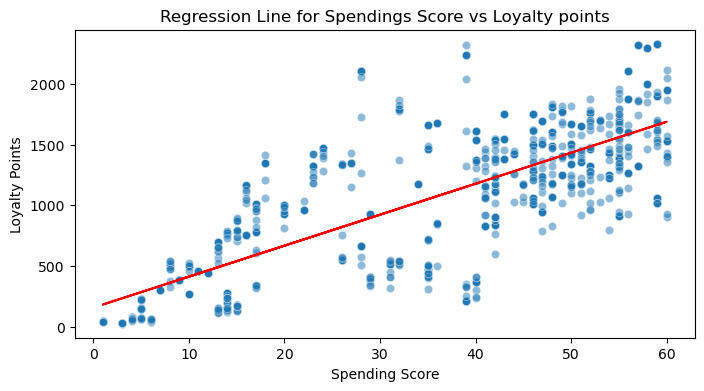

In [57]:
# Define independent and dependent variable 
x_sub = spend_score_below60['spending_score']
y_sub = spend_score_below60['loyalty_points']

# Run the OLS regression model 
lr_sub = sm.OLS(y_sub, sm.add_constant(x_sub)).fit()

# Print the regression results
print(lr_sub.summary())

# Create a variable to store predicted loyalty points 
y_pred_lr = lr_sub.predict(sm.add_constant(x_sub))

# Set plot size 
plt.figure(figsize=(8, 4), dpi=100)

# Plot the graph with a regression line.
sns.scatterplot(data= spend_score_below60, x= x_sub, y= y_sub, alpha=0.5)

# Set labels and title 
plt.title("Regression Line for Spendings Score vs Loyalty points")
plt.xlabel("Spending Score")
plt.ylabel("Loyalty Points")

# Add Regression line 
plt.plot(x_sub, y_pred_lr, color='red')

# Show the plot
plt.show()


In [58]:
# Run the Breusch-Pagan test function on the model residuals and x-variables.
test_sub = sms.het_breuschpagan(lr_sub.resid, lr_sub.model.exog)

# Create a variable to store the outputs
terms = ['LM stat', 'LM Test p-value', 'F-stat', 'F-test p-value']
#Print the results of the Breusch-Pagan test.
print(dict(zip(terms, test_sub)))

{'LM stat': 0.7254432417144341, 'LM Test p-value': 0.3943642106649332, 'F-stat': 0.7247664973646792, 'F-test p-value': 0.3947341709226181}


The fit of the model has increased significanlty, and heteroskedasticity is not present. This has been an notable improvement but we have other predictors to explore and we might adjust our model. 

Nevertheless, the correlation is statistical significant and a starting point for future segmentations. 

## Income vs loyalty

Text(0.5, 1.0, 'Scatterplot of Income Vs Loyalty Points')

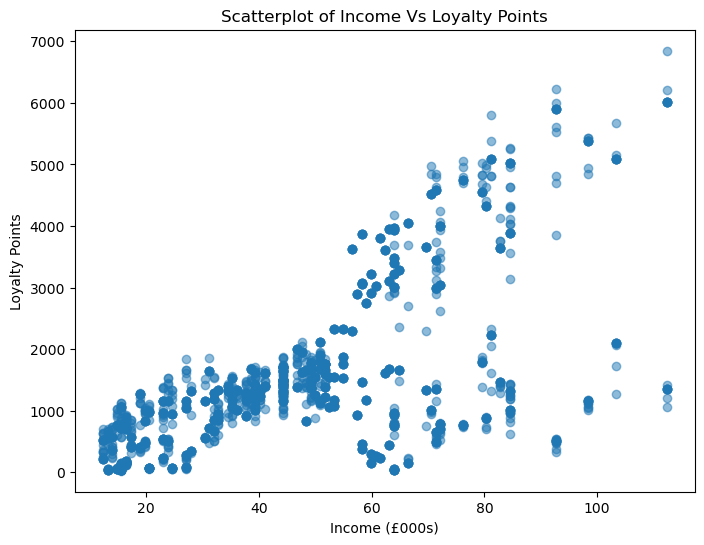

In [59]:
# Define independent variable.
x_1 = reviews_sub['income']

# Define dependent variable.
y = reviews_sub['loyalty_points']

#Check for linearity with scatterplot
plt.figure(figsize= (8,6))
plt.scatter(x_1,y, alpha=0.5)
plt.xlabel('Income (£000s)')
plt.ylabel('Loyalty Points')
plt.title('Scatterplot of Income Vs Loyalty Points')

The Relation income -loyalty point is more linear for those earning 60k or less per year. For higher earners, the increase of income do not always signifies increase in loyalty points. 

Unsuprisingly, this follow similar patterns observed from the scatterplot spending score vs loyaly points since disposable income is a  factor influencing spending behaviours. 

We will deploy a linear regression model to validate statistically our observations and to understand how much income can explain loyalty points variation. 

In [60]:
# Create OLS regression model and print summary of metrics.
lr_1 = sm.OLS(y,sm.add_constant(x_1)).fit()

# Summary of Regression results 
print(lr_1.summary())

                            OLS Regression Results                            
Dep. Variable:         loyalty_points   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     1222.
Date:                Mon, 09 Sep 2024   Prob (F-statistic):          2.43e-209
Time:                        16:27:57   Log-Likelihood:                -16674.
No. Observations:                2000   AIC:                         3.335e+04
Df Residuals:                    1998   BIC:                         3.336e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -65.6865     52.171     -1.259      0.2

**R-squared(0.38)**: 38% of the variation in loyalty points is explained by income increase.

**Estimated coefficient(34.18)**: For each £1000 increase in income  we observe on average an increase of 34.18 loyalty points 

**Kurtosis(3.590)**: heavy tails, indicating outliers in the distribution of residuals.

**P value (0.000)**: Indicating that the relationship observed between income  and loyalty points is highly statistically significant and not due to chance. We are 95% confident that the loyalty point sensitivity to income is within the region of 32.270 < x > 36.106

In [61]:
# Extract the estimated parameters.
print("Parameters: ", lr_1.params)  

# Extract the standard errors.
print("Standard errors: ", lr_1.bse)  

# Extract the predicted values.
print("Predicted values: ", lr_1.predict(sm.add_constant(x_1)))

Parameters:  const    -65.686513
income    34.187825
dtype: float64
Standard errors:  const     52.170717
income     0.977925
dtype: float64
Predicted values:  0        354.823741
1        354.823741
2        382.857758
3        382.857758
4        410.891774
           ...     
1995    2821.817228
1996    3102.157397
1997    3102.157397
1998    3298.395515
1999    3102.157397
Length: 2000, dtype: float64


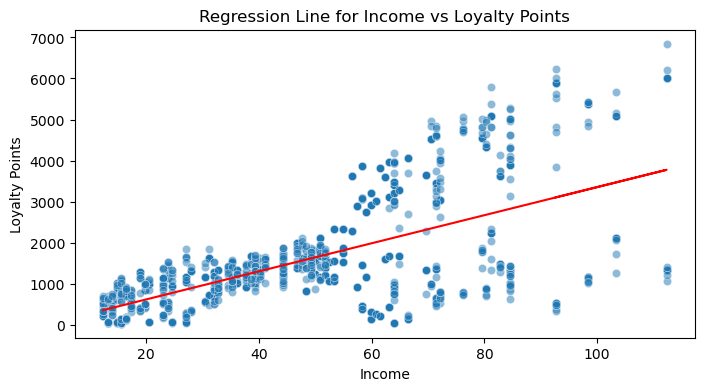

In [62]:
# Create a variable to store predicted loyalty points
y_pred_lr_1 = lr_1.predict(sm.add_constant(x_1))

# Set plot size
plt.figure(figsize=(8, 4), dpi=100)

# Plot the graph with a regression line
sns.scatterplot(data=reviews_sub, x='income', y='loyalty_points', alpha=0.5)

# Set labels and title
plt.title("Regression Line for Income vs Loyalty Points")
plt.xlabel('Income')
plt.ylabel('Loyalty Points')

# Add Regression line
plt.plot(reviews_sub['income'], y_pred_lr_1, color='red')

# Show the plot
plt.show()

**Check Heteroscedasticity**

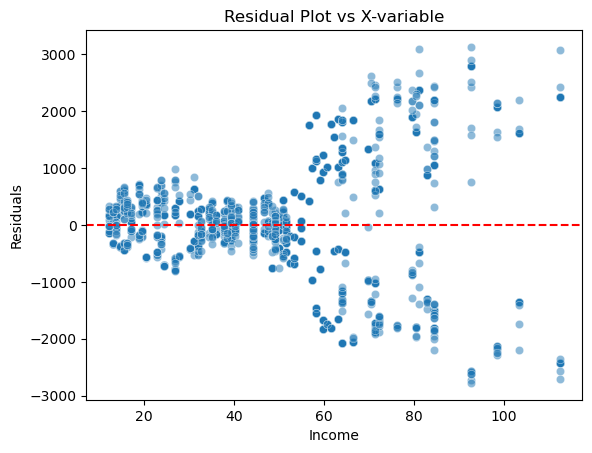

{'LM stat': 1038.6445487288279, 'LM Test p-value': 7.153051772823832e-228, 'F-stat': 2158.6311344219316, 'F-test p-value': 3.68e-320}


In [63]:
# Calcolate residuals
residuals_lr_1= lr_1.resid

# Set Residual Plot 
sns.scatterplot(x=x_1, y=residuals_lr_1, alpha=0.5)

# Add the zero residual line to improve clarity
plt.axhline(y=0, color='red', linestyle='--')
# Set title and axis labels
plt.title("Residual Plot vs X-variable")
plt.xlabel("Income")
plt.ylabel("Residuals")
plt.show()

# Run the Breusch-Pagan test function on the model residuals and x-variables.
test_lr_1 = sms.het_breuschpagan(lr_1.resid, lr_1.model.exog)

# Create a variable to store the outputs
terms = ['LM stat', 'LM Test p-value', 'F-stat', 'F-test p-value']
#Print the results of the Breusch-Pagan test.
print(dict(zip(terms,test_lr_1)))

For customers with incomes over than 60k, the data points appear more spread out and show greater variability in loyalty points, meaning that this simple linear model with income alone is not able to capture/explain the variabily of loyalty points.

This suggest that income alone cannot explain the variability in loyalty points and that some high earners are not engaging effectively with the current loyalty point system. As consequence we observe variance in distribution of residuals.

**These subgroups must be targeted differently**

## Income <= 60k vs Loyalty Points 

                            OLS Regression Results                            
Dep. Variable:         loyalty_points   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                     1389.
Date:                Mon, 09 Sep 2024   Prob (F-statistic):          1.36e-211
Time:                        16:28:07   Log-Likelihood:                -10615.
No. Observations:                1398   AIC:                         2.123e+04
Df Residuals:                    1396   BIC:                         2.124e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -50.2057     34.849     -1.441      0.1

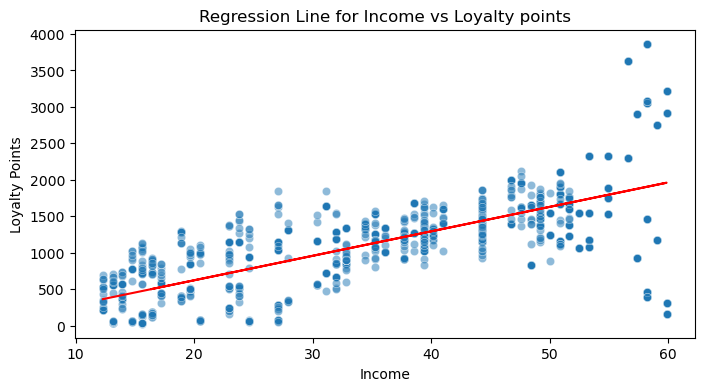

In [66]:
income_below60 = reviews_sub[reviews_sub['income']<= 60]

# Define independent and dependent variable 
x_sub2 = income_below60['income']
y_sub2 = income_below60['loyalty_points']

# Run the OLS regression model 
lr_sub2 = sm.OLS(y_sub2, sm.add_constant(x_sub2)).fit()

# Print the regression results
print(lr_sub2.summary())

# Create a variable to store predicted loyalty points 
y_pred_lr2 = lr_sub2.predict(sm.add_constant(x_sub2))

# Set plot size 
plt.figure(figsize=(8, 4), dpi=100)

# Plot the graph with a regression line.
sns.scatterplot(data=income_below60 , x= x_sub2, y= y_sub2, alpha=0.5)

# Set labels and title 
plt.title("Regression Line for Income vs Loyalty points")
plt.xlabel("Income")
plt.ylabel("Loyalty Points")

# Add Regression line 
plt.plot(x_sub2, y_pred_lr2, color='red')

# Show the plot
plt.show()



The model best fit the data points in this subset, suggesting stronger linear relationship betweeen income and loyalty points for this subgroups.  


###  Age vs Loyalty

**From the correlation table above, we already have observed that age and loyalty points are not correlated (-0.042)
. We will run a linear regression to validate the statistical significance**

In [67]:
# Define independent variable.
x_2 = reviews_sub['age']

# Define dependent variable.
y= reviews_sub['loyalty_points']

# Create model and print summary of metrics.
lr_2 = sm.OLS(y, sm.add_constant(x_2)).fit()

# View regression table 
print(lr_2.summary())

                            OLS Regression Results                            
Dep. Variable:         loyalty_points   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.606
Date:                Mon, 09 Sep 2024   Prob (F-statistic):             0.0577
Time:                        16:28:08   Log-Likelihood:                -17150.
No. Observations:                2000   AIC:                         3.430e+04
Df Residuals:                    1998   BIC:                         3.431e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1736.5177     88.249     19.678      0.0

**R-squared(0.002): almost equal to 0, age is not a factor influencing loyalty points.**

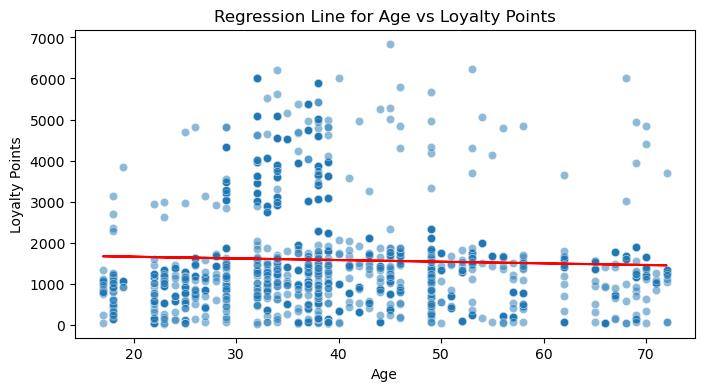

In [68]:
# Create a variable to store predicted loyalty points
y_pred_lr_2 = lr_2.predict(sm.add_constant(x_2))

# Set plot size
plt.figure(figsize=(8, 4), dpi=100)

# Plot the graph with a regression line
sns.scatterplot(data=reviews_sub, x='age', y='loyalty_points', alpha=0.5)

# Set labels and title
plt.title("Regression Line for Age vs Loyalty Points")
plt.xlabel('Age')
plt.ylabel('Loyalty Points')

# Add Regression line
plt.plot(reviews_sub['age'], y_pred_lr_2, color='red')

# Show the plot
plt.show()

**Different age groups do not present different level of engagement with loyalty points accumulation.**

## MultiLinear Regression Income and Spending Score vs Loyalty Points

In [69]:
# Define dependent variable 
y = reviews_sub['loyalty_points']

# Define the 2 explanatory variables 
X = reviews_sub[['income','spending_score']]

# Test with 3 variables: 
#X = reviews_sub[['income','spending_score','age']]

# Split the data in training (80%) and test (20%) subsets
X_train,X_test, y_train, y_test= train_test_split(X,y, test_size= 0.2, random_state= 42)

# Run the regression model on training data using OLS
mlr = sm.OLS(y_train, sm.add_constant(X_train)).fit()

# Set the predicted response vector
y_pred_mlr = mlr.predict(sm.add_constant(X_test))

# Print Regression table
print( mlr.summary())  

                            OLS Regression Results                            
Dep. Variable:         loyalty_points   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     3895.
Date:                Mon, 09 Sep 2024   Prob (F-statistic):               0.00
Time:                        16:28:09   Log-Likelihood:                -12307.
No. Observations:                1600   AIC:                         2.462e+04
Df Residuals:                    1597   BIC:                         2.464e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1700.3237     39.588    -42.

Given the small increase in adjusted R-squared resulting from the inclusion of age as the third explanatory variable, we will prioritize model simplicity and retain the two-variable model. (Run X 'test with 3 variables to gauge the difference)

MLR with spending score and income explain the 83% of the variation of loyalty points. 

- For each income increase of £1000, spending score being equal, we will observe an increment on average of 34.33 loyalty points
- If spending score increase of 1 unit, loyalty points will increase on average of 32.64 points. 

p value < 0.005 confirm the relationships observed are highly statistically significant and not due to chance. 

**Check assumption if assumptions of Regression Models are met**

**Check Multicollinearity**

In [70]:
# Create an empty Df to store Variance Inflation Factors  
vif = pd.DataFrame() 

# Calculate the 'vif' for each value.
vif["VIF Factor"] = [variance_inflation_factor(X_test.values, 
                                               i) for i in range(X_test.values.shape[1])] 
# Create the feature columns.
vif['features'] = X_test.columns  

# Print the values to two decimal points.
print(vif.round(2))  

   VIF Factor        features
0        2.65          income
1        2.65  spending_score


VIF less than 5, that the correlation between spending score and income is not strong enough to produce multicollinearity (X: income and spending_score are sufficiently independent)

**Check Homoskedasticity**

In [71]:
# Run the Breusch-Pagan test function on the model residuals and x-variables.
test_mlr = sms.het_breuschpagan(mlr.resid, mlr.model.exog)

# Create a variable to store the outputs
terms = ['LM stat', 'LM Test p-value', 'F-stat', 'F-test p-value']
#Print the results of the Breusch-Pagan test.
print(dict(zip(terms, test_mlr)))

{'LM stat': 45.09301971749995, 'LM Test p-value': 1.6150098749733065e-10, 'F-stat': 23.156868353553804, 'F-test p-value': 1.2194606385156922e-10}


LM Test p-value(1.6150098749730242e-10): with p_value < 0.005, we reject the null hypothesis of residuals equality of distribution and assume that Heteroskedasticity is present.

**Visualise Heteroskedasticity** 

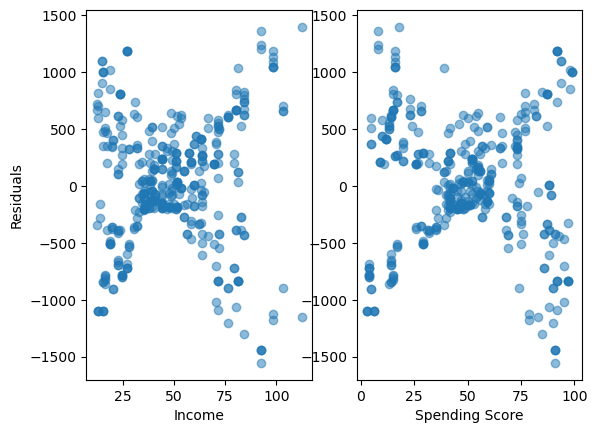

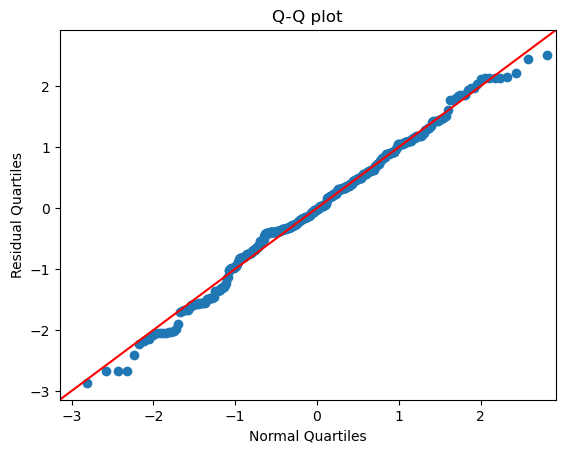

In [72]:
# Calculate the Residuals 
mlr_residuals = y_pred_mlr - y_test

# Plot the residuals=(y-predictd- y-observed) versus the x-variables.
#Plot the residuals versus the x-variables in the test set
plt.subplot(1,2,1)
plt.scatter(X_test["income"], mlr_residuals, alpha= 0.5)
plt.xlabel("Income")
plt.ylabel("Residuals")

plt.subplot(1,2,2)
plt.scatter(X_test["spending_score"], mlr_residuals,alpha= 0.5)
plt.xlabel("Spending Score")


# Plot the quartiles of the residuals versus the quartiles of the N(0,1)
# The fit=True argument first Standardises the observed data (Residuals) before plotting them
sm.qqplot(mlr_residuals, fit=True, line='45')
plt.ylabel("Residual Quartiles")
plt.xlabel("Normal Quartiles")
plt.title("Q-Q plot")
plt.show()

**Addressing Heteroskedasticity: Improve MLR predictive power using Squared Root Transformation**

<Axes: xlabel='loyalty_points', ylabel='Count'>

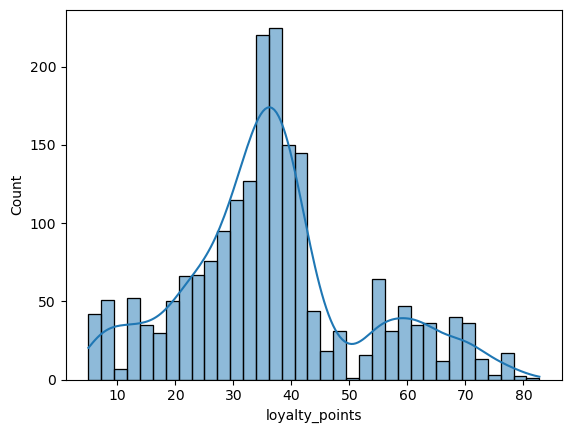

In [73]:
#Define transformed y as the square root of target variable
y_sqrt = np.sqrt(y)

#check distribution
sns.histplot(y_sqrt,kde=True)


In [74]:
# Split the data in training (80%) and test (20%) subsets
X_train,X_test, y_train, y_test= train_test_split(X,y_sqrt, test_size= 0.2, random_state= 42)

# Run the regression model on training data using OLS
sqr_mlr = sm.OLS(y_train, sm.add_constant(X_train)).fit()

# Print Regression table
print(sqr_mlr.summary())

# Set the predicted response vector
y_pred_mlr_sqr = sqr_mlr.predict(sm.add_constant(X_test))

# Run the Breusch-Pagan test function on the model residuals and x-variables.
test = sms.het_breuschpagan(sqr_mlr.resid, sqr_mlr.model.exog)

# Create a variable to store the outputs
terms3 = ['LM stat', 'LM Test p-value', 'F-stat', 'F-test p-value']
#Print the results of the Breusch-Pagan test.
print(dict(zip(terms3, test)))


                            OLS Regression Results                            
Dep. Variable:         loyalty_points   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     6319.
Date:                Mon, 09 Sep 2024   Prob (F-statistic):               0.00
Time:                        16:28:12   Log-Likelihood:                -4909.8
No. Observations:                1600   AIC:                             9826.
Df Residuals:                    1597   BIC:                             9842.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -4.2610      0.389    -10.

Reducing the variance of loyalty points though square root transformation has meant a better fit.
Breuch Pagan test outputs indicate homosteskedatsicy.

- **R-squared(0.88)**: 88% of the variation in loyalty points is explained by income and spending score .

**Check Ditribution of residuals**

Text(0.5, 1.0, 'Q-Q plot')

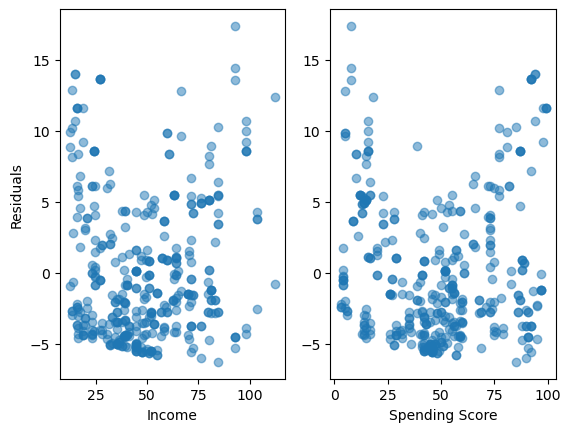

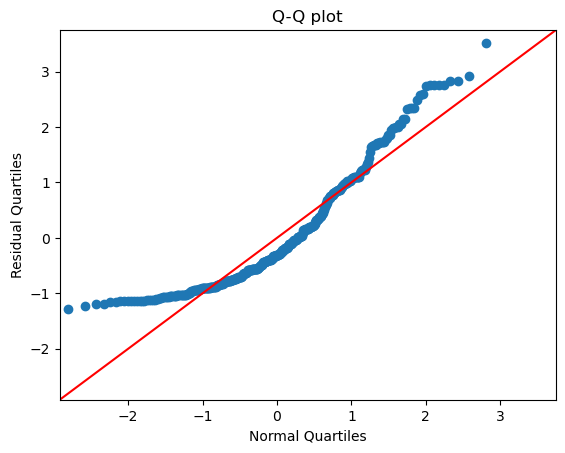

In [75]:
# Calculate the Residuals (square root of y-predicted - square root of y-observed)
sqr_mlr_residuals = y_pred_mlr_sqr - y_test

#Plot the residuals versus the x-variables in the test set
plt.subplot(1,2,1)
plt.scatter(X_test['income'], sqr_mlr_residuals, alpha= 0.5)
plt.xlabel('Income')
plt.ylabel('Residuals')

plt.subplot(1,2,2)
plt.scatter(X_test["spending_score"], sqr_mlr_residuals,alpha= 0.5)
plt.xlabel("Spending Score")

# Plot the quartiles of the residuals versus the quartiles of normal distribution
sm.qqplot(sqr_mlr_residuals, fit=True, line='45')
plt.ylabel('Residual Quartiles')
plt.xlabel('Normal Quartiles')
plt.title('Q-Q plot')

**Evaluate the MLR model**

To evaluate the prediction power before and past the transformation, we will square the model prediction in the squared root scale(√y). This will ensure the same scale and allow comparison.

In [76]:
# Transform y_pred_mlr_sqr predictions back to original scale
y_predicted = np.square(y_pred_mlr_sqr)

# Calculate mean absolute error
mae_mlr = metrics.mean_absolute_error(y_test, y_pred_mlr)
mae_mlr_sqr = metrics.mean_absolute_error(y_test, y_predicted)
print('Mean Absolute Error (mlr):', mae_mlr)
print('Mean Absolute Error (mlr sqr):', mae_mlr_sqr)

# Calculate mean squared error
mse_mlr = metrics.mean_squared_error(y_test, y_pred_mlr)
mse_mlr_sqr = metrics.mean_squared_error(y_test, y_predicted)
print('Mean Squared Error (mlr):', mse_mlr)
print('Mean Squared Error (mlr sqr):', mse_mlr_sqr)

# Calculate root mean squared error
rmse_mlr = np.sqrt(mse_mlr)
rmse_mlr_sqr = np.sqrt(mse_mlr_sqr)
print('Root Mean Squared Error (mlr):', rmse_mlr)
print('Root Mean Squared Error (mlr sqr):', rmse_mlr_sqr)

Mean Absolute Error (mlr): 1652.449480227472
Mean Absolute Error (mlr sqr): 1503.1897514496056
Mean Squared Error (mlr): 3668407.905876696
Mean Squared Error (mlr sqr): 3562542.4950709688
Root Mean Squared Error (mlr): 1915.308827807332
Root Mean Squared Error (mlr sqr): 1887.46986600342


**N.b: MLR redisidual Plotting and new predictions will be performed in R**

The MLR Model has improved and prediction accuracy consequently, but it is still not good enough, exhibiting  very high Average Absolute Errors and Average Square Root Errors. 

To this end, we will deploy a CART Decision Tree model. This will allow to:
1) Understand how different features influence loyalty points and assess their importance.
2) Control the impact of high variance in the target variable on predictions. This issue should be less pronounced due to the model nature to partition data rather than assuming linearity (hence better accomodating the complexities present in this data)


## Step 1. Summary of observations and insights from  Step 1.

Income, Spending Score and Age alone have been shown not sufficiently strong individual factors explaining loyalty points. The relationship income vs loyalty points and their visual representation with scatterplots indicate d


Our analysis, individuated that income and spending score together explain a large portion of the variability in loyalty points.
Age was excluded from the model given the non linear relationship with loyalty income and to preserve model semplicity. 

This provides valuable **actionable insights for Turtle Games**: 

Income and loyalty point as key driver for loyalty points accumulation:
For each £1000 increase of income we should observed on average + 34.33 loyalty points
If spending score increase of 1 unit, loyalty points will increase on average of 32.64 points.

On average customers with higher incomes and higher spending scores tend to accumulate more loyalty points but not in a fashion linear way.

**Particualty it confirm that to enhance loyalty program effectiveness Turtle games need to tailor strategies to different income and spending segments.** 


# Step 2: Exploring the data structure using decision trees.

Decision Trees are known to better handle non linearity of relatioships as indicated from above analysis, given their nature to partition the data rather than assuming linearity. 

Through features importance we will better understand how the different features (variables) contribute to the accumulation of loyalty points.


In [85]:
# Settings for the notebook.
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [15, 10]

**Data Preparation** 

In [86]:
# Create your new DataFrame.
df2= reviews2.copy()

# Drop columns to prepare df to ML
df2.drop(columns=['product','review','summary'],inplace=True)

In [87]:
#Check null values
print(df2.isnull().sum())

#Check categorical data 
variable_count(df2,'gender')
variable_count(df2,'education')


gender            0
age               0
income            0
spending_score    0
loyalty_points    0
education         0
dtype: int64
Record Count: 
   gender  count
0  Female   1120
1    Male    880
Record Count: 
      education  count
0      graduate    900
1           PhD    460
2  postgraduate    400
3       diploma    190
4         Basic     50


In [88]:
# Transform categorical data using dummies variables 

#Create columns list 
categorical_cols= ['gender','education']

df2= pd.get_dummies(df2, columns= categorical_cols, drop_first = True)
df2.head()

age  income  spending_score  loyalty_points  gender_Male  education_PhD  \
0   18   12.30              39             210         True          False   
1   23   12.30              81             524         True          False   
2   22   13.12               6              40        False          False   
3   25   13.12              77             562        False          False   
4   33   13.94              40             366        False          False   

   education_diploma  education_graduate  education_postgraduate  
0              False                True                   False  
1              False                True                   False  
2              False                True                   False  
3              False                True                   False  
4              False                True                   False

In [89]:
# Specify Y.
y_dtr = df2['loyalty_points']

# Specify X.
X_dtr = df2.drop('loyalty_points',axis=1)

In [90]:
# Review X and Y.
print(X_dtr)
print(y_dtr)

      age  income  spending_score  gender_Male  education_PhD  \
0      18   12.30              39         True          False   
1      23   12.30              81         True          False   
2      22   13.12               6        False          False   
3      25   13.12              77        False          False   
4      33   13.94              40        False          False   
...   ...     ...             ...          ...            ...   
1995   37   84.46              69        False           True   
1996   43   92.66               8        False           True   
1997   34   92.66              91         True          False   
1998   34   98.40              16         True           True   
1999   32   92.66               8         True           True   

      education_diploma  education_graduate  education_postgraduate  
0                 False                True                   False  
1                 False                True                   False  
2        

## Create the Decision Tree Regressor model

In [91]:
# Split the data into test and train data.
X_train,X_test, y_train,y_test = train_test_split(X_dtr,y_dtr, test_size=0.3, random_state = 42)

# Create instance to hold the decision tree regressor.
dtr = DecisionTreeRegressor(random_state=42)

# Train the model with data
dtr.fit(X_train,y_train)

# Predict loyalty points based on test data
y_pred_dtr = dtr.predict(X_test)

# View predictions array 
y_pred_dtr

array([  65., 3398., 2750., 1122., 1622., 1605.,  266.,  970., 1060.,
       3634., 1338., 1777., 1752., 2235.,  696., 1430., 1675.,  463.,
        334.,   67., 1504.,  338.,  962., 1424., 1605., 1248., 4747.,
       1344.,  500., 1151.,  515.,  443.,  499., 1617., 1651., 1328.,
       1177., 1658., 1281., 1177.,  926., 1623., 1395., 5084., 4844.,
        238., 1617., 1622., 1322., 1317.,  894.,  942.,  904.,  179.,
       1601.,  994.,  664., 4844.,  881., 3285., 1404., 1281., 1098.,
       1622., 1346.,  579., 3636.,  225., 1222., 1585., 1338., 4320.,
       5377., 1177., 3478.,  926., 1350., 3636., 1347.,  334., 1232.,
       1014., 1379.,  871., 1267., 1605.,  478., 1281., 1703., 1129.,
       4829., 1383.,  138., 1503.,  133.,   60., 1395., 1042., 1037.,
       1321., 1547., 5895., 1151.,  648., 1159., 1379.,  476., 1338.,
       1067.,  443., 3455., 1684., 1637.,  994., 3015.,  881., 1673.,
       4588.,  925., 1233.,  236.,  338., 1617., 1376., 5895., 4799.,
       1355., 1998.,

## Evaluate the Model Diagnostics

In [92]:
#Calculate R-squared
print('R-squared:', dtr.score(X_test,y_test))

# Calculate mean absolute error
mae_dtr = metrics.mean_absolute_error(y_test, y_pred_dtr)
print('Mean Absolute Error:',mae_dtr )

# Calculate mean squared error
mse_dtr = metrics.mean_squared_error(y_test,y_pred_dtr )
print('Mean Squared Error:', mse_dtr)

# Calculate root mean squared error
rmse_dtr = np.sqrt(mse_dtr)
print('Root Mean Squared Error:', rmse_dtr)

R-squared: 0.994986812999381
Mean Absolute Error: 32.885
Mean Squared Error: 8120.345
Root Mean Squared Error: 90.1129568930018


X features explain the total variation of loyalty points. This kind of R-squared is great,maybe too much to be true. 
We will apply post pruning strategies to restrict the complexity of the tree. 

## Model Pruning through Establishing the Maximum Depth**

Text(0.5, 1.0, 'R² Score vs. Max Decision Tree Depth')

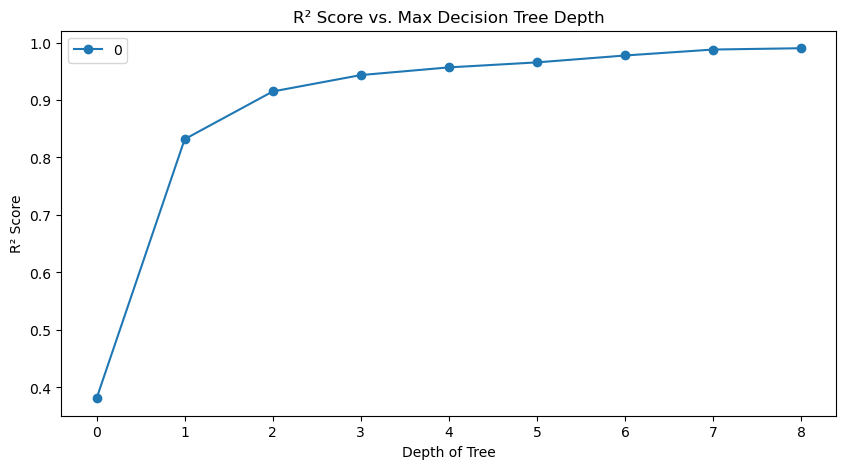

In [93]:
# List of values to try for max_depth:
max_depth_range = list(range(1, 10))

# List to store the r squared  for each value of max_depth:
r_squared = []

for depth in max_depth_range:    
    dtr_2 = DecisionTreeRegressor(max_depth=depth, random_state=10)
    dtr_2.fit(X_train, y_train)
    score = dtr_2.score(X_test, y_test)
    r_squared.append(score)

    
# Plot accuracy values across the range of depth values evaluated
plt.rcParams['figure.figsize'] = [10, 5]
r_squared_values = pd.DataFrame(r_squared)
r_squared_values.plot(marker='o')
plt.xlabel("Depth of Tree")
plt.ylabel("R² Score")
plt.title("R² Score vs. Max Decision Tree Depth")


After 4 branches, the R² reaches a plateau. Additional depth in the tree might not improve significantly the model's perfomance but adds unecessary complexity. 

To mitigate the risk of overfitting or underfitting we will evaluate the optimal pruning with K fold crossvalidation. 
Instead of splitting the data in training and test data with 80-20 split, data into dived in K subsets (5 ind this case) of approximately equal size, and the model trained and tested 5 times. 

This significantly reduces underfitting as we are using most of the data for training(fitting), and also significantly reduces overfitting

**K Fold Cross Validation** https://www.kaggle.com/code/satishgunjal/tutorial-k-fold-cross-validation

In [94]:
# Split the data in 5 folds 
kf =KFold(n_splits=5, shuffle=True, random_state=42)

# Initialise the counter
cnt=1

# Loop through each fold
for train_index, test_index in kf.split(X_dtr, y_dtr):
    print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    cnt += 1
    
# Define Root Mean Squared difference 
def rmse(score):
    rmse = np.sqrt(-score) 
    print(f'rmse= {"{:.2f}".format(rmse)}')


Fold:1, Train set: 1600, Test set:400
Fold:2, Train set: 1600, Test set:400
Fold:3, Train set: 1600, Test set:400
Fold:4, Train set: 1600, Test set:400
Fold:5, Train set: 1600, Test set:400


In [95]:
# Perform cross-validation and calculate RMSE averaged across the folds 
score = cross_val_score(DecisionTreeRegressor(random_state= 42), X_dtr, y_dtr, cv=kf, scoring="neg_mean_squared_error")
print(f'Scores for each fold: {score}')
rmse(score.mean())

Scores for each fold: [-6554.8225 -6459.9325 -7386.2025 -6649.1325 -9712.8175]
rmse= 85.75


In [96]:
# Define max depth list to iterate
max_depth = [1,2,3,4,5,6,7,8]

for val in max_depth:
    #
    score = cross_val_score(DecisionTreeRegressor(max_depth= val, random_state= 42), X_dtr, y_dtr, cv= kf, scoring="neg_mean_squared_error")
    print(f'For max depth: {val}')
    rmse(score.mean())

For max depth: 1
rmse= 1022.04
For max depth: 2
rmse= 533.99
For max depth: 3
rmse= 382.89
For max depth: 4
rmse= 316.93
For max depth: 5
rmse= 273.93
For max depth: 6
rmse= 227.32
For max depth: 7
rmse= 180.48
For max depth: 8
rmse= 138.81


Averaged RMSE from 5 iterations  indicates max_depth = 8 as the best parameter and we will retrain the model accordingly. 

Subsequently, we will evaluate the RMSE differences between the DTR outputs on unseen test data (20% split) and data tested using 5-fold cross-validation. If the differences are large, it means that the model does not generalise well on unseen data. 

**Evaluate the performance of the DTR based on Pruning Strategy**

In [97]:
# Define Decision Tree Regressor Model with optimal max depth
dtr_pruned = DecisionTreeRegressor(max_depth=7, random_state=10)
#dtr_pruned = DecisionTreeRegressor(max_depth=8, random_state=10)   # Test to see how the model generalise on unseen data with this max_depth 

# fit the model
dtr_pruned.fit(X_train, y_train)

# Make predictions
y_pred_dtr_pruned = dtr_pruned.predict(X_test)

# Evaluate the model 
#Calculate R-squared
print('R-squared:', dtr_pruned.score(X_test,y_test))

# Calculate mean absolute error
mae_dtr_pruned = metrics.mean_absolute_error(y_test,y_pred_dtr_pruned )
print('Mean Absolute Error:',mae_dtr )

# Calculate mean squared error
mse_dtr_pruned = metrics.mean_squared_error(y_test,y_pred_dtr_pruned )
print('Mean Squared Error:', mse_dtr)

# Calculate root mean squared error
rmse_dtr_pruned = np.sqrt(mse_dtr_pruned)
print('Root Mean Squared Error:', rmse_dtr_pruned)

R-squared: 0.9773975521545389
Mean Absolute Error: 32.885
Mean Squared Error: 8120.345
Root Mean Squared Error: 191.3409940976475


We observed a significant difference in RMSE between the average from k-fold cross-validation and the test data when using max_depth = 8

Max depth = 7 has demonstrated more consistent performance, with the model performing similarly on unseen test data as it did during cross-validation. 


MAE, indicates that the difference between average predictions and observed is relatively small (32.85 loyalty points off), however, the RMSE output indicted large errors (outliers) in the predictions (212.34 loyalty points off) 

RMSE - MAE = 179.2  There are large errors in predictions of loyalty points.

This means the model might be capturing the overall trend well but is struggling with certain predictions, likely due to outliers or high variance in the loyalty points data and complexities not gathered from this data source. 

Comparing the differences with the outputs of the linear regression model, the variation in prediction of RMSE is however significantly reduced. 

**Feature Importance Engeenering: Unpruned tree vs Pruned** 

In [98]:
# create list with columns names for plotting
feature_cols = [c for c in X_dtr.columns]  
feature_cols

# Extract feature importance
feature_importance = dtr.feature_importances_

# Create df for visualisation
feature_importance_df = pd.DataFrame({'feature':feature_cols, 'importance':feature_importance})\
.sort_values(by='importance', ascending= True)

# View df
feature_importance_df

feature  importance
6      education_graduate    0.000158
7  education_postgraduate    0.000159
4           education_PhD    0.000385
3             gender_Male    0.000452
5       education_diploma    0.000591
0                     age    0.016944
2          spending_score    0.483595
1                  income    0.497716

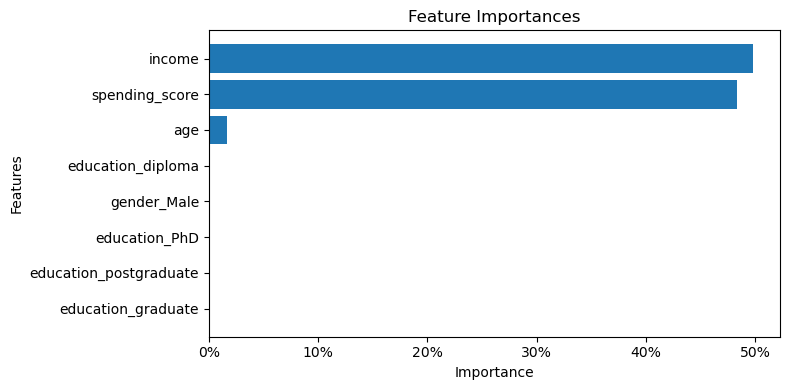

In [99]:
# Visualise Feature Importance Before Pruning 
# Create Bar plot
plt.figure(figsize=(8, 4))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])

# Set title and axis labels
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')

# Format x label using get current axis method to aid visualisation
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))

plt.tight_layout()
plt.show()

Income & spending behaviours are considered the most important predictor. Age shows some significance but importatnly less than the first two. The other features have an impact close to the 0. 

**We will rerun the model with the pruned tree to determine wheather feature significance changes** 

In [100]:
# Extract feature importance After Pruning 
feature_importance_pruned = dtr_pruned.feature_importances_

# Create DataFrame for visualisation
feature_importance_pruned_df = pd.DataFrame({'feature': feature_cols, 'importance': feature_importance_pruned})\
.sort_values(by='importance', ascending=True)

# View df storing feature importance values
feature_importance_pruned_df

feature  importance
4           education_PhD    0.000005
6      education_graduate    0.000031
3             gender_Male    0.000059
7  education_postgraduate    0.000117
5       education_diploma    0.000323
0                     age    0.013433
2          spending_score    0.486433
1                  income    0.499599

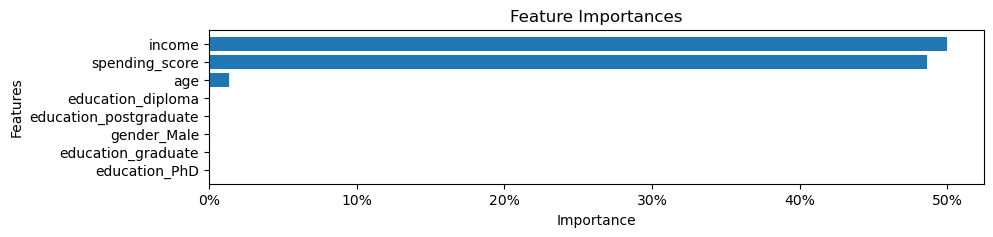

In [101]:
# Create bar plot to display feature importance 
plt.figure(figsize=(10, 2))

plt.barh(feature_importance_pruned_df['feature'], feature_importance_pruned_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')

# Format x ticks to aid interpretation
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))


#plt.tight_layout()
plt.show()

Pruning did not affect feature importance. 
Income and Spending score were confirmed being important predictors for loyalty point accumulations. 

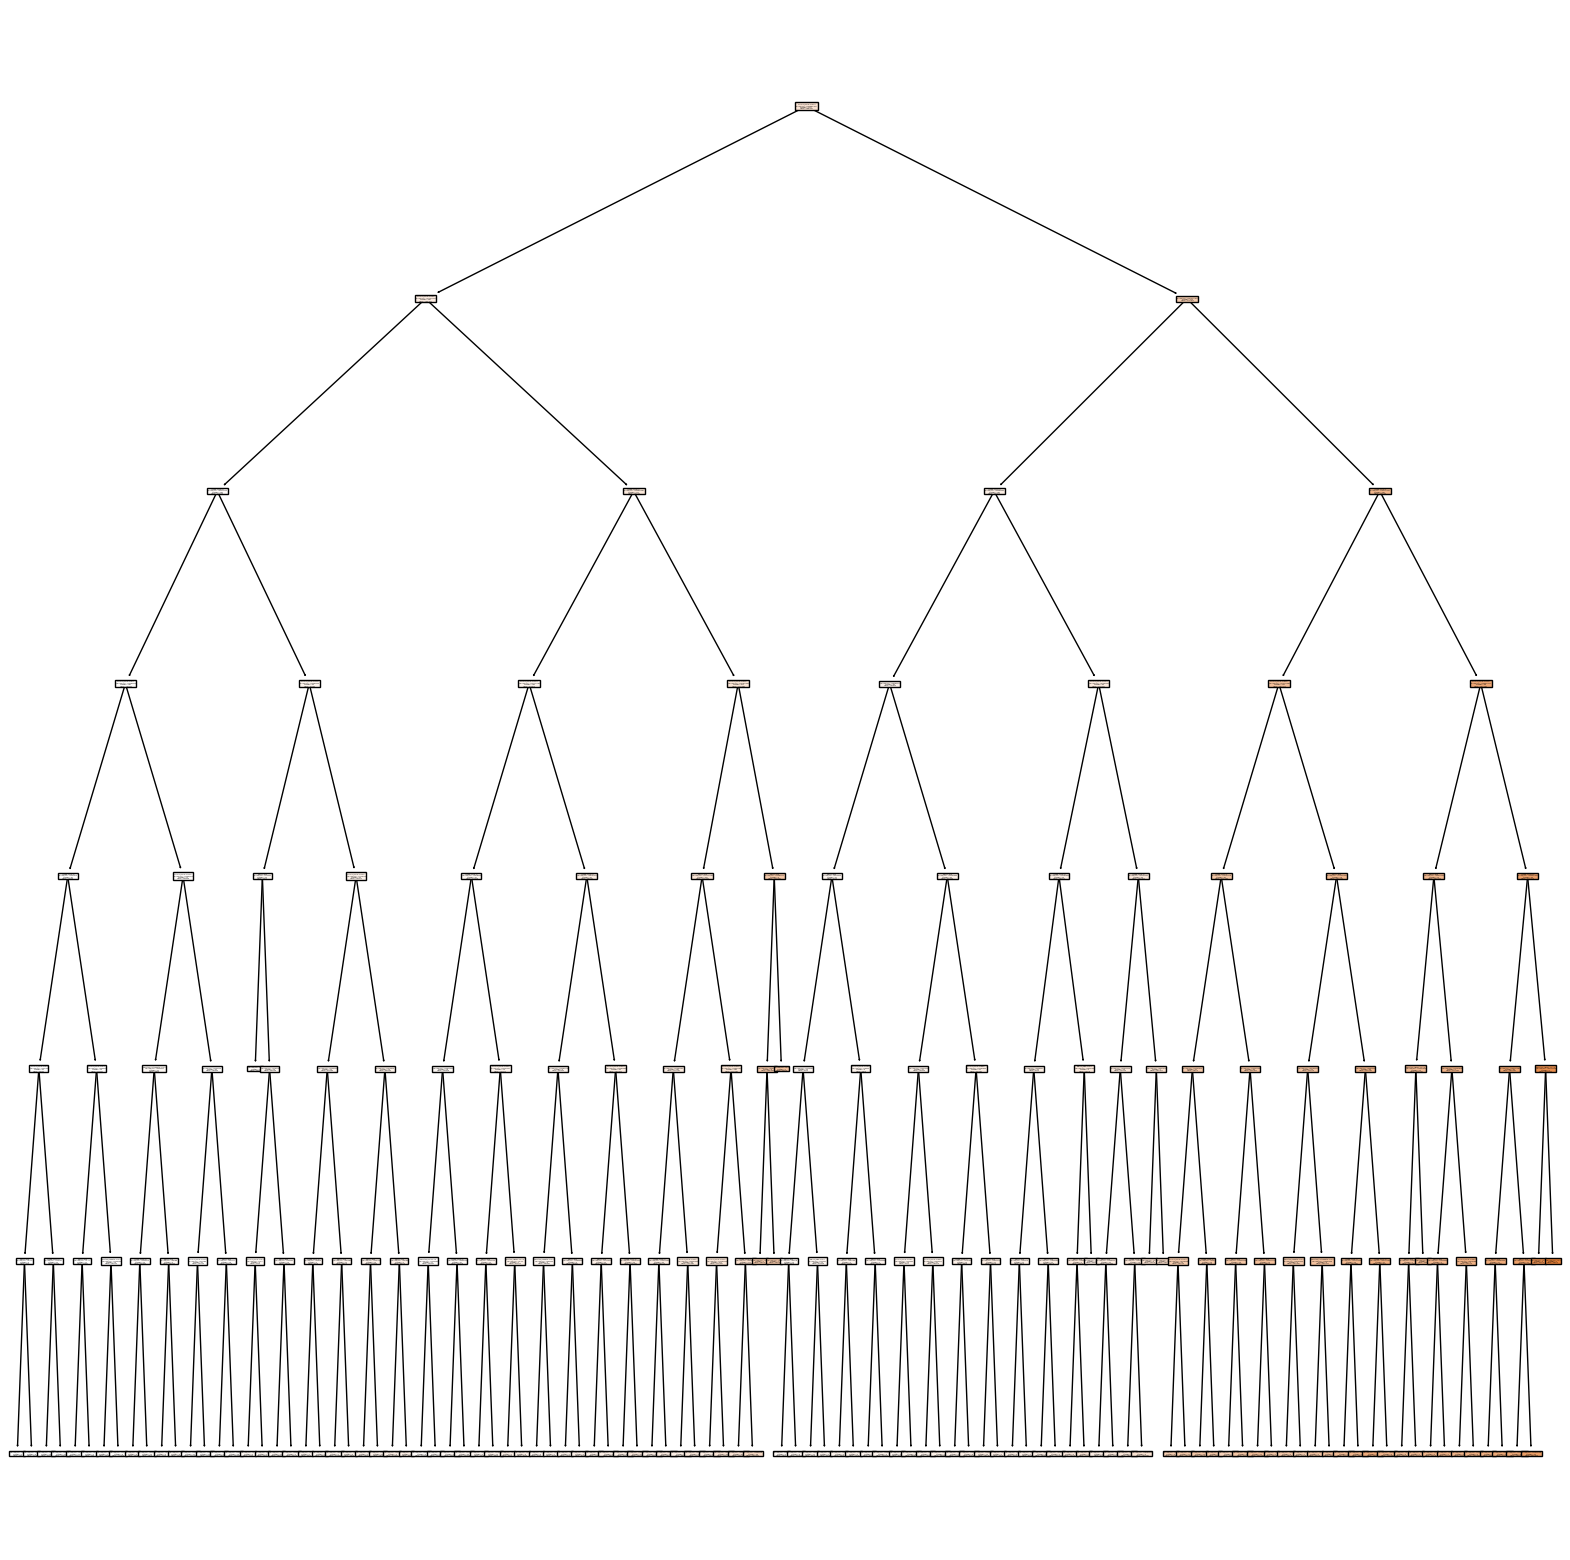

In [102]:
# Plot the model 
plt.figure(figsize = (20,20))
plot_tree(dtr_pruned, feature_names = feature_cols ,filled=True)
plt.show()

In [103]:
# Create subset data to include optimal features 
# Keep optimal featured and target variable 
df_opt_features = reviews2[['income', 'spending_score', 'loyalty_points']]

# View df 
df_opt_features.head()

income  spending_score  loyalty_points
0   12.30              39             210
1   12.30              81             524
2   13.12               6              40
3   13.12              77             562
4   13.94              40             366

In [104]:
#Define X and Y 
X_opt = df_opt_features[['income', 'spending_score']]
y = df_opt_features['loyalty_points']

# Split the data into training and test subsets (70/30 split)
X_train_opt, X_test_opt, y_train_opt, y_test_opt = train_test_split(X_opt, y, test_size=0.3, random_state=42)

# Initialize the DecisionTreeRegressor
dtr_opt = DecisionTreeRegressor(max_depth = 7, random_state=42)

# Fit the model
dtr_opt.fit(X_train_opt, y_train_opt)

# Make predictions
y_pred_opt = dtr_opt.predict(X_test_opt)

**Check Cross validate with K Fold**

In [105]:
# Split the data in 5 folds 
kf =KFold(n_splits=5, shuffle=True, random_state=42)

# Initialise the counter
cnt=1

# Loop through each fold
for train_index, test_index in kf.split(X_opt, y):
    print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    cnt += 1
    
# Define Root Mean Squared difference 
def rmse(score):
    rmse = np.sqrt(-score) 
    print(f'rmse= {"{:.2f}".format(rmse)}')

# Perform cross-validation and calculate RMSE averaged across the folds 
score = cross_val_score(DecisionTreeRegressor(random_state= 42), X_opt, y, cv=kf, scoring="neg_mean_squared_error")
print(f'Scores for each fold: {score}')
rmse(score.mean())


# Define max depth list to iterate
max_depth = [1,2,3,4,5,6,7,8]

for val in max_depth:
    #
    score = cross_val_score(DecisionTreeRegressor(max_depth= val, random_state= 42), X_opt, y, cv= kf, scoring="neg_mean_squared_error")
    print(f'For max depth: {val}')
    rmse(score.mean())

Fold:1, Train set: 1600, Test set:400
Fold:2, Train set: 1600, Test set:400
Fold:3, Train set: 1600, Test set:400
Fold:4, Train set: 1600, Test set:400
Fold:5, Train set: 1600, Test set:400
Scores for each fold: [-29936.18767486 -15562.86157902 -28338.56730455 -11199.73481751
 -35594.82082545]
rmse= 155.33
For max depth: 1
rmse= 1022.04
For max depth: 2
rmse= 533.99
For max depth: 3
rmse= 382.89
For max depth: 4
rmse= 313.68
For max depth: 5
rmse= 260.69
For max depth: 6
rmse= 226.79
For max depth: 7
rmse= 205.46
For max depth: 8
rmse= 194.27


**Evaluate the adjusted DTR model**

In [106]:
# Evaluate the model 
#Calculate R-squared
print('R-squared:', dtr_opt.score(X_test_opt,y_test_opt))

# Calculate mean absolute error
mae_dtr_opt = metrics.mean_absolute_error(y_test_opt,y_pred_opt )
print('Mean Absolute Error:',mae_dtr )

# Calculate mean squared error
mse_dtr_opt = metrics.mean_squared_error(y_test_opt,y_pred_opt )
print('Mean Squared Error:', mse_dtr)

# Calculate root mean squared error
rmse_dtr_opt = np.sqrt(mse_dtr_opt)
print('Root Mean Squared Error:', rmse_dtr_opt)

R-squared: 0.9701676009674446
Mean Absolute Error: 32.885
Mean Squared Error: 8120.345
Root Mean Squared Error: 219.8236313149256


Model RMSE - Avg RMSE from k fold = 219.83 - 205.46 = 14 suggesting that the model optimised with most important features generalise well on unseen data. 

R-squared: 97%. The model fits the data very well and explains most of the variability in the target variable.

General accuracy 
RSME - MAE = 219.82 -32.88 = 186.94. While the the tuned model perform well on average, there are predictions where the errors are much larger. 


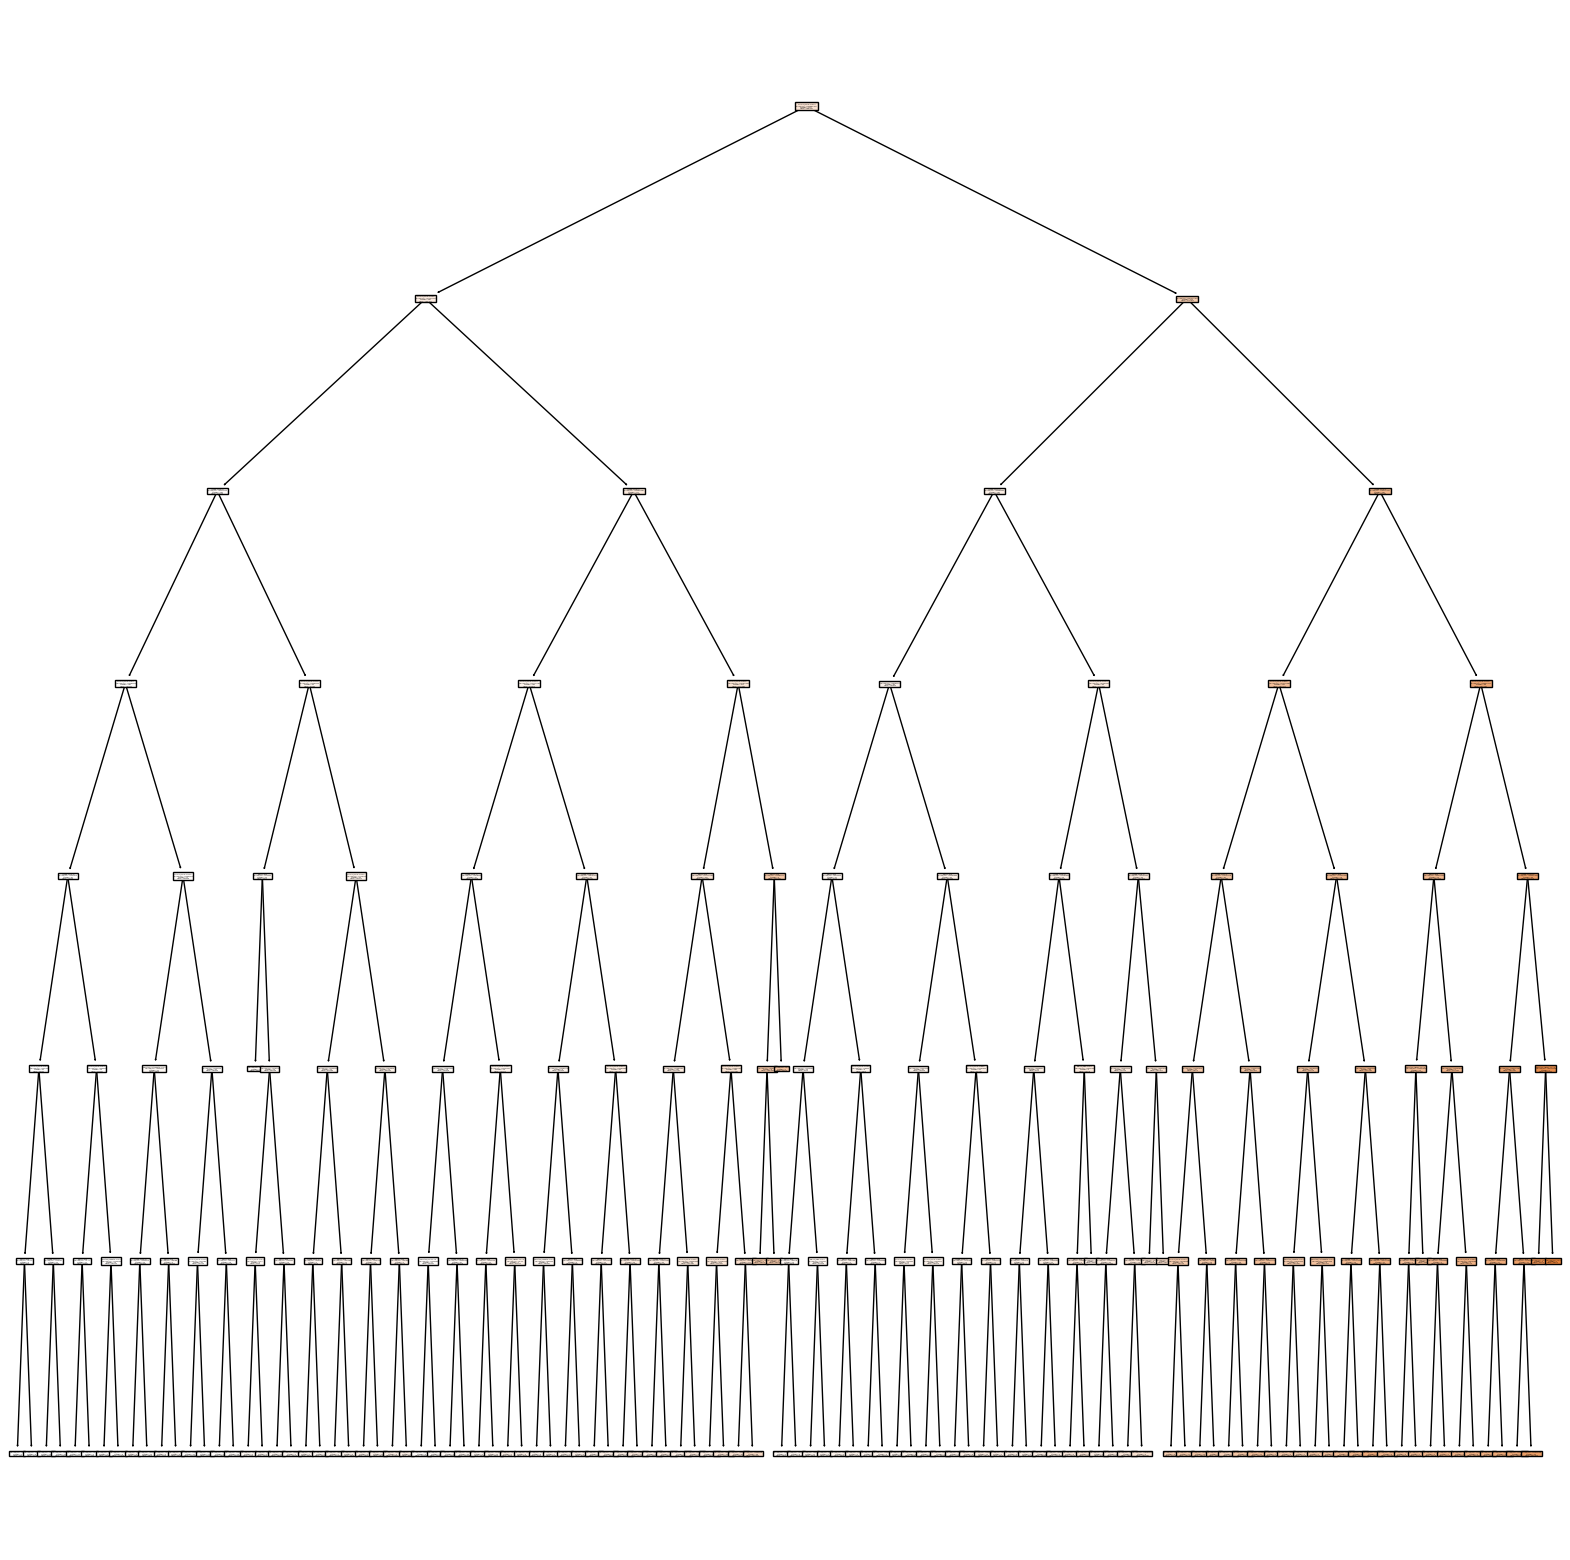

In [107]:
# Plot the model 
plt.figure(figsize = (20,20))
plot_tree(dtr_pruned,feature_names = feature_cols,filled=True)
plt.show()


**Based on the observation above, we concluded that income and spending score are imporant predictors of loyalty points. This also means that targeting customers based on their yearly income and spending behaviours is likely to result in different engagements and accumulation of loyalty points.

**Moreover, this suggest that a Tiered loyalty program that leverage distinct income and spending behaviours might be more appropriate. But how to segment? Next we will apply K-means modelling to predict clusters.**

With Decision Tree we have calculated predictions more accurate than MLR however large errors are still an issue. This suggest that important varibales or interaction are missing from the current dataset and we need to refine feuture engeneering.

# 

# Step 3. Customer Segmentation 

Through K-means modelling, we will identify groups within the customer base that can be used to target specific market segments. 
We will first look a bivariate segmentation to determine if segments based on income and spending score are possible. 

**Create a Subset**

In [108]:
#Create df containing income and spending_score columns.
df_2= reviews2[['income', 'spending_score']]

# View DataFrame.
df_2.head()

income  spending_score
0   12.30              39
1   12.30              81
2   13.12               6
3   13.12              77
4   13.94              40

In [109]:
# Sense-check the new df
print(df_2.info())

# Explore the data.
df_2.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   income          2000 non-null   float64
 1   spending_score  2000 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 31.4 KB
None


income  spending_score
count  2000.000000     2000.000000
mean     48.079060       50.000000
std      23.123984       26.094702
min      12.300000        1.000000
25%      30.340000       32.000000
50%      47.150000       50.000000
75%      63.960000       73.000000
max     112.340000       99.000000

Features are already scaled. Don't require further data preparation

## Explore Data Distribution and Relationships

<Axes: xlabel='income', ylabel='spending_score'>

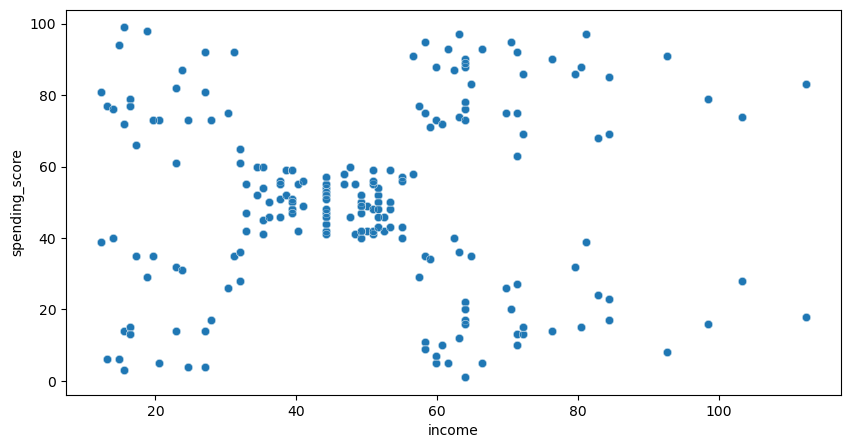

In [110]:
# Create a scatterplot with Seaborn.
sns.scatterplot(data = df_2, x = 'income', y='spending_score',alpha=0.5)

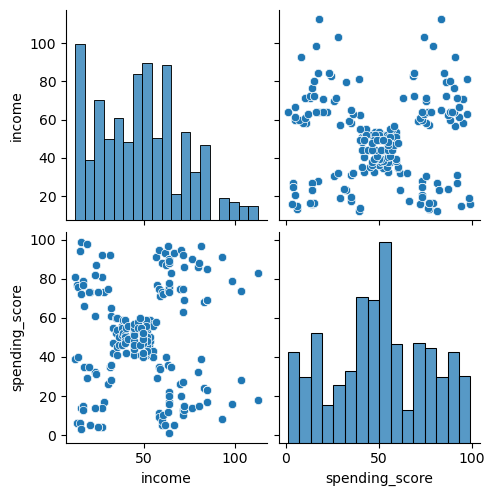

In [111]:
# Create a pairplot with Seaborn.
sns.pairplot(df_2)

Visually, we can already identify 5 distinct clusters. Next, we will validate this observation using the K-Means clustering algorithm.

## Cluster Analysis: 2 Variables

Text(0, 0.5, 'WCSS')

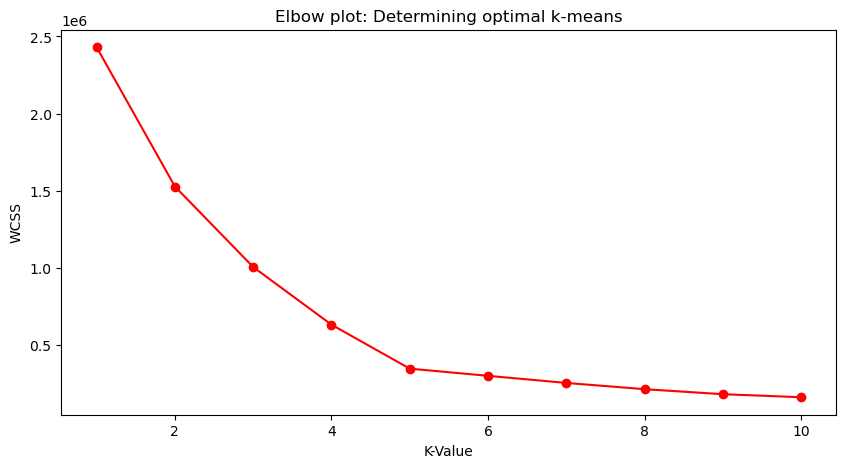

In [112]:
#Create an empty list where to append the intra-clusters sum of the square distance score (wcss).
wcss=[]

# Determine the number of clusters: Elbow method. 
for i in range(1,11):
    km=KMeans(n_clusters= i, n_init=10, init='k-means++', random_state = 42)
    km.fit(df_2)
    # Calculate inertia and append to the list 
    wcss.append(km.inertia_)

# Plot the elbow 
plt.plot(range(1,11), wcss , marker= 'o', color = 'r')

# Set title and labels
plt.title('Elbow plot: Determining optimal k-means')
plt.xlabel('K-Value')
plt.ylabel('WCSS')


The within cluster distance (inertia) start decreasing more slowly in correspodence of k-value: 5, which suggest the optimal number of clusters. 

**Validate outputs with the Silhouette method**

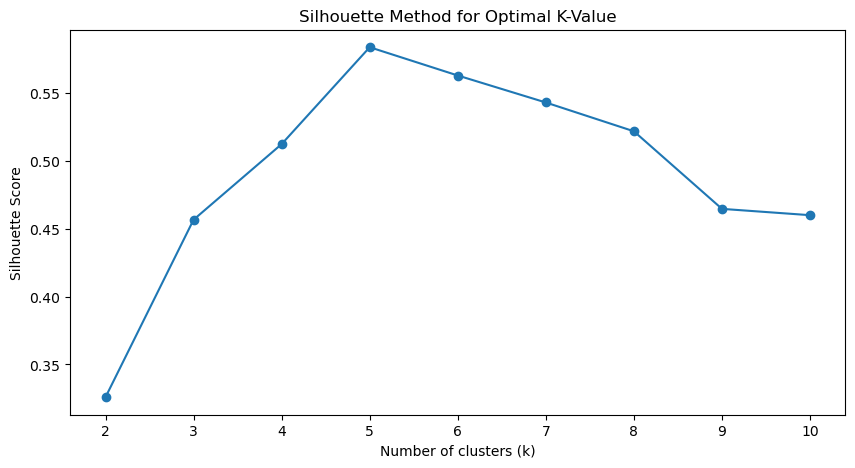

In [113]:
# Determine the number of clusters: Silhouette method.

# Initialize empty list to store silhouette scores
sil = []

# Iterate over each value of k
for k in range(2,11):
    # Initialize KMeans clustering with current k
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(df_2)
    
    # Predict clusters and calculate silhouette score
    y_pred_c = km.predict(df_2)
    sil_avg = silhouette_score(df_2, y_pred_c)
    
    # Append the silhouette score to the list
    sil.append(sil_avg)

# Plot the silhouette scores against k values
plt.plot(range(2,11), sil, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal K-Value')
plt.show()


Although the Silhouette score identified and confirmed 5 clusters as optimal, we will experiment with different numbers of clusters to evaluate the model's efficacy in segmenting the data

## Evaluate k-means model at different values of *k*

**K-Values = 4**

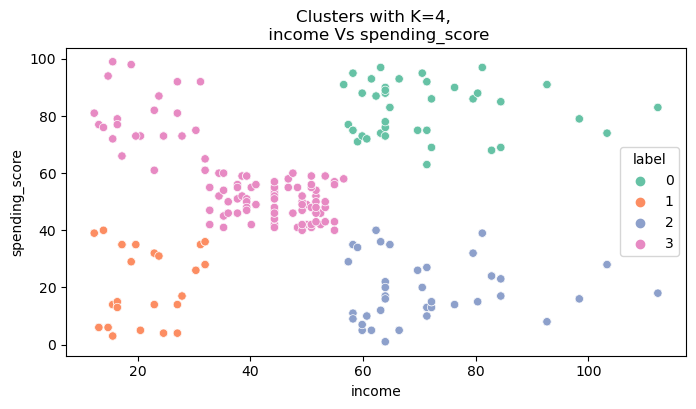

In [114]:
# Call the Apply K-Means function and plot the results
clusters_4 = apply_K_Means_plot(df_2, 4, 'income', 'spending_score', random_state = 42)


In this case, the 4 clusters do not represent customer features well. Group 1, in particular, presents high intra-cluster variability with income and spending score too heterogeneous.

**K-Values = 6**

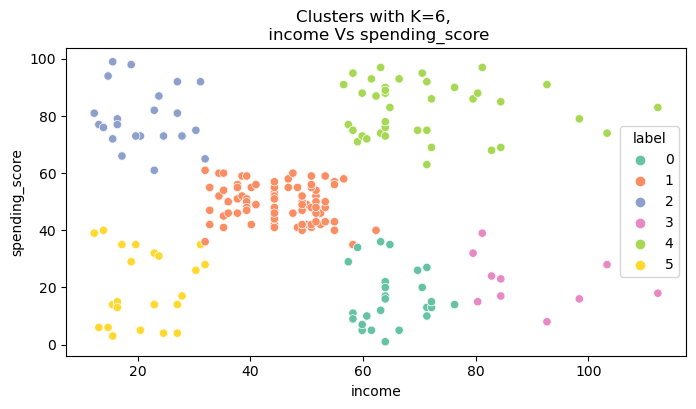

In [115]:
# Call the Apply K-Means function and plot the results
clusters_6 = apply_K_Means_plot(df_2, 6, 'income', 'spending_score', random_state = 42)

6 clusters perform better than previoius example (k=4).The additional cluster has identified more nuanced behaviors among customers. However, some data points are overlapped, suggesting that k=6 might not be the optimal number of clusters 

**K-Values = 5**

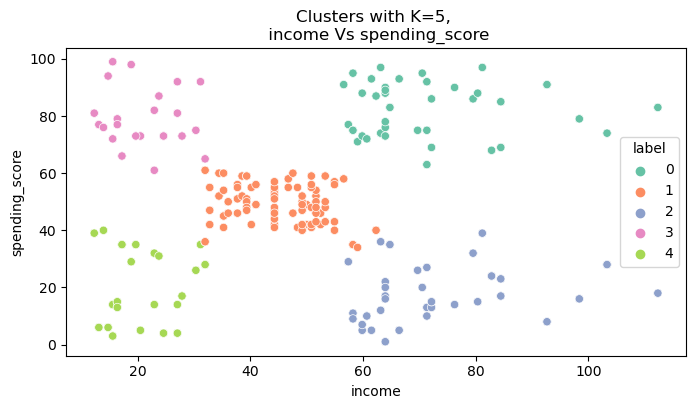

In [116]:
# Call the Apply K-Means function and plot the results
clusters_5 = apply_K_Means_plot(df_2, 5, 'income', 'spending_score', random_state = 42)

k=5 performs well and similarly to k=6 presents slight overlap. To decide between the two clustering options, we will prioritize the solution with the higher silhouette score (k=5) since higher scores suggest better-defined and more distinct clusters. 

For our business objectives, the additional clusters do not add significant value for marketing targeting. Specifically, the group with high income and low spending behaviour (Group 4) presents uniform conservative spending patterns. Varying income within this group does not necessitate a change in the marketing approach.

### Cluster Labeling and Features Exploration

***IMPORTANT***
**Although the random state, apply_K_Means_plot user function could produce differrent labels orders so that i.e 0 is not high income-high spending but medium income-moderate spending. 

**If labelling does not correspond to the cluster order set in this notebook and technical report, customise this according to the new outputs to produce next plots. **

K-Means model individuated 5 distinct behavioural clusters: 
- 0 = 'Luxury Spenders' high income, high spending score.(annual income 60-100k, spending score 70-100) (will be target group)
- 1 = Practical Shoppers' average income - moderate spending behaviours.(annual income 30-60k, spending score 40-60)
- 2 = 'Savvy savers' high income -low spending score.(annual income 60-100k, spending score 5-40)
- 3 = 'Aspirational Spenders' low income-high spending behaviours. (annual income 10-30k, spending score 60-100)
- 4 = 'Cautious Shoppers' low income, low spending behaviours.(annual income 10-30k, spending score 5-40)

Now, we will delve deeper into understanding each cluster's characteristics and develop strategic insights for the marketing team.

In [117]:
# Append predicted clusters on review data
reviews_final['label']= clusters_5

# Create descriptive marketing labels 
marketing_labels = {
    0: 'Luxury Spenders',
    1: 'Practical Shoppers',
    2: 'Savvy Savers',
    3: 'Aspirational Spenders',
    4: 'Cautious Shoppers'}

# Create a new column with descriptive names, replace label values with map function 
reviews_final['marketing_labels'] = reviews_final.label.map(marketing_labels)

# Create a copy
df_segments = reviews_final.copy()

# Display the first few rows of the modified DataFrame
df_segments.head()

gender  age  income  spending_score  loyalty_points education  product  \
0    Male   18   12.30              39             210  graduate      453   
1    Male   23   12.30              81             524  graduate      466   
2  Female   22   13.12               6              40  graduate      254   
3  Female   25   13.12              77             562  graduate      263   
4  Female   33   13.94              40             366  graduate      291   

                                              review  \
0  When it comes to a DM's screen, the space on t...   
1  An Open Letter to GaleForce9*:\n\nYour unpaint...   
2  Nice art, nice printing.  Why two panels are f...   
3  Amazing buy! Bought it as a gift for our new d...   
4  As my review of GF9's previous screens these w...   

                                             summary  label  \
0  The fact that 50% of this space is wasted on a...      4   
1  Another worthless Dungeon Master's screen from...      3   
2                    pretty, but also pretty useless      4   
3                                         Five Stars      3   
4                                         Money trap      4   

        marketing_labels  
0      Cautious Shoppers  
1  Aspirational Spenders  
2      Cautious Shoppers  
3  Aspirational Spenders  
4      Cautious Shoppers

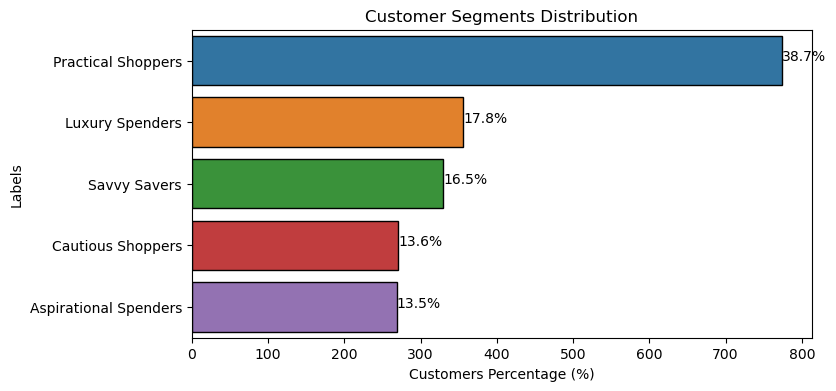

<Figure size 1000x500 with 0 Axes>

In [118]:
# Create countplot to display marketing label distribution
plt.figure(figsize=(8, 4))
ax = sns.countplot(y=df_segments['marketing_labels'], order=df_segments['marketing_labels'].value_counts().index,
                   edgecolor = 'black')

# Annotate the bars with percentages
total = df_segments['marketing_labels'].count()
for p in ax.patches:
    percentage = f'{(p.get_width() / total) * 100:.1f}%'
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y))

# Set title and labels
plt.title('Customer Segments Distribution')
plt.ylabel('Labels')
plt.xlabel('Customers Percentage (%)')

plt.show()
plt.tight_layout()

Almost half of the customer base who purchased a product and left a review presented balanced spending behaviours and moderate incomes; high proportion of high earners with different spending behaviours ranging from more conservative to lavish (luxory spenders and savvy ). This is a good opportunity. 


Let's have a look at other common attributes. We will check avg and std of age and loyalty points to verify weather adding further numerical varibales can further define our segmentation. 

# Defining the avg. Customer Profile by Segment for loyalty points accumulation

In [119]:
# Remove unnecessary columns
df_segments.drop(columns=['review','summary','label'], inplace=True)

# View df 
df_segments.head()

gender  age  income  spending_score  loyalty_points education  product  \
0    Male   18   12.30              39             210  graduate      453   
1    Male   23   12.30              81             524  graduate      466   
2  Female   22   13.12               6              40  graduate      254   
3  Female   25   13.12              77             562  graduate      263   
4  Female   33   13.94              40             366  graduate      291   

        marketing_labels  
0      Cautious Shoppers  
1  Aspirational Spenders  
2      Cautious Shoppers  
3  Aspirational Spenders  
4      Cautious Shoppers

Next We will check avg and std of age and loyalty points to justify the case for further segmentation

In [120]:
# Group by the labeled clusters by avg. loyalty points and age.
cluster_attributes_stats = df_segments.groupby('marketing_labels').agg({
    'loyalty_points': ['mean', 'std'],
    'age': ['mean', 'std']}).reset_index()

#View the df 
cluster_attributes_stats

marketing_labels loyalty_points                    age           
                                   mean         std       mean        std
0  Aspirational Spenders     971.944238  296.173785  31.602230  10.731534
1      Cautious Shoppers     275.059041  198.236064  43.505535  13.961553
2        Luxury Spenders    3988.238764  898.409322  35.592697   7.299612
3     Practical Shoppers    1420.382429  322.530608  42.129199  15.721916
4           Savvy Savers     911.760606  545.849379  40.666667  11.357594

This further validates/display differenlty, our regression and decision tree outcomes, where variations in spending score and income explain the positive variations in loyalty points (i.e high income, high spending score represented by luxury shoppers have on average the highest loyalty points).

**It also highlights that clustering based on loyalty points would not provide further meaningful business insights**

**On the other hand, the average age of around 40 yo and limited std across segments suggests that age might not be a defining factor in distinguishing these segments.**


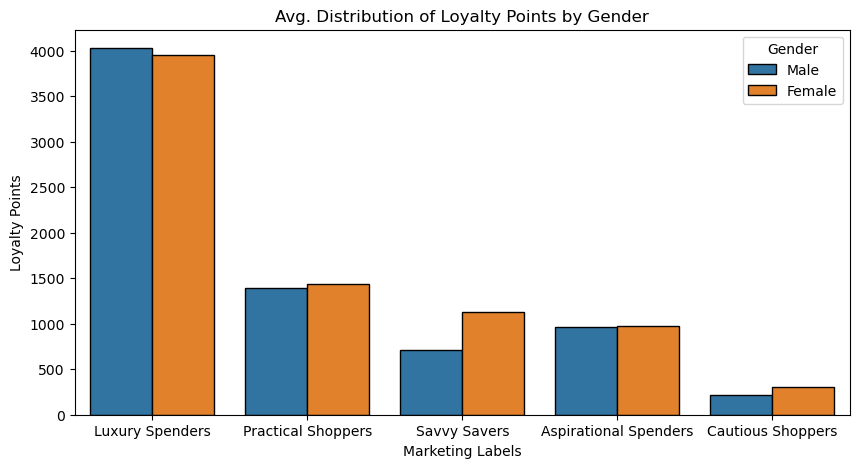

In [121]:
#Look at loyalty points distribution by gender 
avg_cluster_attributes = df_segments.groupby(['marketing_labels', 'gender']).agg({'loyalty_points': 'mean', 'age': 'mean'}) \
    .reset_index() \
    .sort_values(by='loyalty_points', ascending=False)

# View df
avg_cluster_attributes 

# Plot distribution of loyalty points on customer segments  by gender 
#Define size
plt.figure(figsize=(10, 5))

ax = sns.barplot(data= avg_cluster_attributes, x = 'marketing_labels', y='loyalty_points', hue ='gender', edgecolor = 'black')

# Set title, labels and legend
ax.set_title('Avg. Distribution of Loyalty Points by Gender')
ax.set_xlabel('Marketing Labels')
ax.set_ylabel('Loyalty Points')
legend = ax.legend(title='Gender')

This tell us that:

Females tend to accrue more loyalty points than males across all segments, except for luxury spenders. 
This finding is particularly relevant because we have observed similar patterns of income and spending scores across genders, suggesting that these variables do not influence their loyalty points accumulation.

But why there a  gender gap? and why this is particularly pronounced on cautious shoppers and savvy savers??

Could this be due to higher satisfaction levels among female customers on average or are there other factors such as engagement/ frequency of purchase on play? 

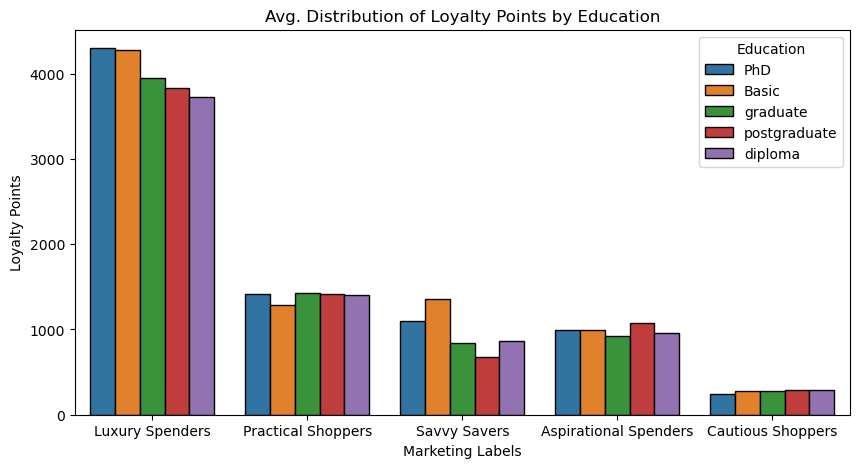

In [122]:
# Create df grouping marketings segments by education divided by avg loyalty points
avg_edu_loyalty_by_cluster= df_segments.groupby(['marketing_labels','education'])['loyalty_points'].mean()\
    .reset_index() \
    .sort_values(by='loyalty_points', ascending=False)

# Plot distribution of loyalty points on customer segments  by education 
#Define size
plt.figure(figsize=(10, 5))

ax = sns.barplot(data= avg_edu_loyalty_by_cluster, x = 'marketing_labels', y='loyalty_points', hue ='education', edgecolor = 'black')

# Set title,labels and legend
ax.set_title('Avg. Distribution of Loyalty Points by Education')
ax.set_xlabel('Marketing Labels')
ax.set_ylabel('Loyalty Points')
legend = ax.legend(title='Education')

Customer segments by Education did not show specific patterns in loyalty engagements.

##  Summary of Observations and Insight 

Through K-Means Classification we individuated 5 distinct groups with different disposable income and spending behaviours. 

Based on this grouping the loyalty program should subdivide members into different categories with differing levels of benefit. (Tiered loyalty)


**high potential for profitability and engagement: Luxory Spenders, Practical Shoppers and Savvy Savers**

**"Luxury Spenders":** are highly valued customers, affluent individuals who enjoy spending. Marketing strategies should focus on exclusivity and high-end experience. Loyalty Programs could highlight personalized shopping experiences, invitations to exclusive events, and premium customer service leveraging the pyscology of benefits (Gold Status)
https://link.springer.com/article/10.1007/s11002-011-9160-3


**Practical Shoppers":**  Middle-income customers with moderate spending habits. (also high value for the business because of consistency of purchases). Marketing strategies could emphasise value-for-money and quality products with promotions that appeal to their balanced lifestyle.Tiered rewards based on cumulative spending over time, with incentives like cashback or product upgrades for reaching higher tiers might be ideal. 

**'Savvy Savers'**: Low spending individuals with high disposable income, suggesting they prioritise saving over spending. Marketing strategies could highlight long-term benefits and quality. Offering loyalty programs or discounts for long-term savings might attract their attention. 

**"Aspirational Spenders"** Low-income individuals who tend to spend a lot. Focus on affordability and aspirational branding for marketing. Loyalty program that could offer flexible payment options (instalments plans) and value bundles could attract this segment.

**Cautious Shoppers** low income and low spending. Marketing strategies could focus on essential products, discounts, and budget-friendly options. 


**Next step analysis**: We need to gather sales data and create a profiling based on avg sales for each cluster. 

Reccomendations : 
- Encode gender and education variables and check weather relationship demographic of marketing labels by loyalty points exist.  hypothesis testing (t-test for gender and chi-square for education) of associations might be a valid solution.

This will allow to investigate whether certain demographic characteristics are statisticallly associated with higher engagement in the loyalty system.
 

# Step 4: NLP for Marketing Strategy 

Customer reviews were downloaded from the Turtle Games website. This data will guide the marketing department in planning future campaigns. Specifically, it aims to identify:

- The 15 most commonly used words in online product reviews.
- A selection of 20 positive and negative reviews received from the website.
- Overall sentiment towards Turtle Games products."

In [123]:
# Create df for sentiment analysis 
df_sentiment = reviews_final.copy()

# Include only necessary columns

df_sentiment =  df_sentiment[['review', 'summary','marketing_labels','product','age','education','gender']]

# Check missing values 
df_sentiment.isna().sum()

review              0
summary             0
marketing_labels    0
product             0
age                 0
education           0
gender              0
dtype: int64

**Check Duplicates**

In [124]:
# check duplicated rows based on the specified columns
duplicated_rows = df_sentiment[df_sentiment[['review', 'summary']].duplicated(keep=False)]

# Display the duplicated rows
duplicated_rows

review     summary       marketing_labels  \
48                             love it  Five Stars     Practical Shoppers   
55                              Great!  Five Stars     Practical Shoppers   
94                               great  Five Stars     Practical Shoppers   
294                               Good  Five Stars     Practical Shoppers   
326                            love it  Five Stars     Practical Shoppers   
371                             Great!  Five Stars        Luxury Spenders   
408                              great  Five Stars      Cautious Shoppers   
416                            love it  Five Stars      Cautious Shoppers   
430                            Love it  Five Stars      Cautious Shoppers   
702                        Love these!  Five Stars     Practical Shoppers   
810                         great game  Five Stars      Cautious Shoppers   
811                         great game  Five Stars  Aspirational Spenders   
933                            Awesome  Five Stars        Luxury Spenders   
959                            Love it  Five Stars        Luxury Spenders   
1006                        great game  Five Stars      Cautious Shoppers   
1037                           Awesome  Five Stars  Aspirational Spenders   
1144                              nice  Five Stars           Savvy Savers   
1145                              nice  Five Stars        Luxury Spenders   
1154            On-time and nice item.  Five Stars           Savvy Savers   
1155            On-time and nice item.  Five Stars        Luxury Spenders   
1186                              Good  Five Stars           Savvy Savers   
1302  Great expansion to a great game.  Five Stars     Practical Shoppers   
1382                           Love it  Five Stars           Savvy Savers   
1414  Great expansion to a great game.  Five Stars           Savvy Savers   
1435                       As expected  Five Stars     Practical Shoppers   
1540                           love it  Five Stars           Savvy Savers   
1544                            Great!  Five Stars        Luxury Spenders   
1553                       As expected  Five Stars           Savvy Savers   
1651                       As expected  Five Stars  Aspirational Spenders   
1713                       Love these!  Five Stars  Aspirational Spenders   

      product  age     education  gender  
48       2079   29      graduate  Female  
55       3896   45      graduate    Male  
94       6721   34      graduate  Female  
294      6770   34      graduate  Female  
326      2849   41      graduate    Male  
371      5726   32       diploma    Male  
408      1459   66           PhD    Male  
416       830   37      graduate  Female  
430      2173   62           PhD    Male  
702      6424   69           PhD    Male  
810      1175   69       diploma    Male  
811      1183   37  postgraduate  Female  
933      4477   33      graduate  Female  
959     11086   32      graduate  Female  
1006     1183   37       diploma  Female  
1037     2130   32  postgraduate  Female  
1144     4712   27  postgraduate    Male  
1145     6271   32         Basic    Male  
1154    11086   45           PhD  Female  
1155     3153   29  postgraduate  Female  
1186     3711   53  postgraduate  Female  
1302     5453   69           PhD    Male  
1382     1031   44           PhD    Male  
1414      811   39      graduate    Male  
1435     4459   23           PhD  Female  
1540    11084   56       diploma  Female  
1544     3267   27  postgraduate    Male  
1553     6431   38           PhD  Female  
1651     4452   35  postgraduate    Male  
1713     7533   18      graduate    Male

While duplicate reviews and summaries have been detected, these are not true duplicates since they pertain to different products. Expanding the view to include age and education categories also confirms that they come from different customers. As such these rows won't be dropped. 

##  Prepare the data for NLP: Text Pre-processing 

In [125]:
# Define stopwords list excluding 'not' 
stop_words = set(stopwords.words('english')) - {'not'}#

# Customise stopwords predefined list 
custom_stopword = {'would','could'}

# Join customised words to original list 
stop_words_update = stop_words.union(custom_stopword)

# Define the tag map for Part of Speech (POS) tagging
tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

# Create a lemmatizer instance
lemma_function = WordNetLemmatizer()

# Apply clean text function and create new columns with cleaned text (reviews,summary)
df_sentiment['cleaned_review'] = df_sentiment['review'].apply(clean_text)
df_sentiment['cleaned_summary'] = df_sentiment['summary'].apply(clean_text)

# View 
df_sentiment.head()

review  \
0  When it comes to a DM's screen, the space on t...   
1  An Open Letter to GaleForce9*:\n\nYour unpaint...   
2  Nice art, nice printing.  Why two panels are f...   
3  Amazing buy! Bought it as a gift for our new d...   
4  As my review of GF9's previous screens these w...   

                                             summary       marketing_labels  \
0  The fact that 50% of this space is wasted on a...      Cautious Shoppers   
1  Another worthless Dungeon Master's screen from...  Aspirational Spenders   
2                    pretty, but also pretty useless      Cautious Shoppers   
3                                         Five Stars  Aspirational Spenders   
4                                         Money trap      Cautious Shoppers   

   product  age education  gender  \
0      453   18  graduate    Male   
1      466   23  graduate    Male   
2      254   22  graduate  Female   
3      263   25  graduate  Female   
4      291   33  graduate  Female   

                                      cleaned_review  \
0  come dm screen space screen absolute premium f...   
1  open letter galeforce9 unpainted miniature not...   
2  nice nice printing two panel fill general forg...   
3                  amaze buy buy gift new dm perfect   
4  review gf9 previous screen completely unnecess...   

                                     cleaned_summary  
0  fact 50 space waste not terribly informative need  
1   another wohless dungeon master screen galeforce9  
2                         pretty also pretty useless  
3                                          five star  
4                                         money trap

While VADER is designed to handle social media text and informal language well, and exclamation and punctuation marks affect the way the model computes sentiment, we have decided to remove these characters so that we can facilitate comparison of clean text with other models.



In [126]:
# Look at random reviews to check effective pre-processing
original_random_review = df_sentiment['review'][72]
print(original_random_review)

random_text_review = df_sentiment['cleaned_review'][72]
print(random_text_review)

This is a tiny book. Only a few pages of stickers. The stickers don't stick very well after the first time placing them. It did however entertain my son during a trip. Stickers for making 4 different robots, all different colors. I would suggest it for younger kids, my son is 3.
tiny book page sticker sticker not stick well first time place however enteain son trip sticker make 4 different robot different color suggest young kid son 3


In [127]:
# Look at random reviews to check effective pre-processing
original_random_review = df_sentiment['review'][1358]
print(original_random_review)

random_text_review = df_sentiment['cleaned_review'][1358]
print(random_text_review)

Lords of Waterdeep is a game we play quite often in my house so when we saw that there was an expansion we had to buy it. This is actually 2 expansions instead of just one and both integrate very well into the game. The major selling point for us was that it added a 6th player to the game and since we are a family of 6 that all enjoy this game it allows us all to play without leaving someone out.

I won't go into the mechanics and game play in this review because other reviewers have done that quite well already probably much better then I could.

I will just keep it simple, if you like Lords of Waterdeep this is an excellent addition that will keep the game interesting and adds a lot of extra content and strategy to the game.
lord waterdeep game play quite often house saw expansion buy actually 2 expansion instead one integrate well game major sell point u add 6th player game since family 6 enjoy game allow u play without leave someone not go mechanic game play review reviewer do quit

**Important:** In both these example number convey meaningful information and as such we decided to keep them. 

Now that the text has been preprocessed we are ready for out analysis of sentiments. We will start by looking at the most common words

## Frequency of Word Distribution

In [129]:
from collections import Counter

# Combine cleaned reviews into a single string
all_reviews = ' '.join(df_sentiment['cleaned_review'])

# Split the combined string into individual words
words = all_reviews.split()

# Count the frequency of each word
freq_dist_of_word = Counter(words)

# Create a DataFrame from the word counts
top_words = pd.DataFrame(freq_dist_of_word.most_common(15), columns=['Common_Words', 'count'])
top_words.style.background_gradient(cmap='Purples')

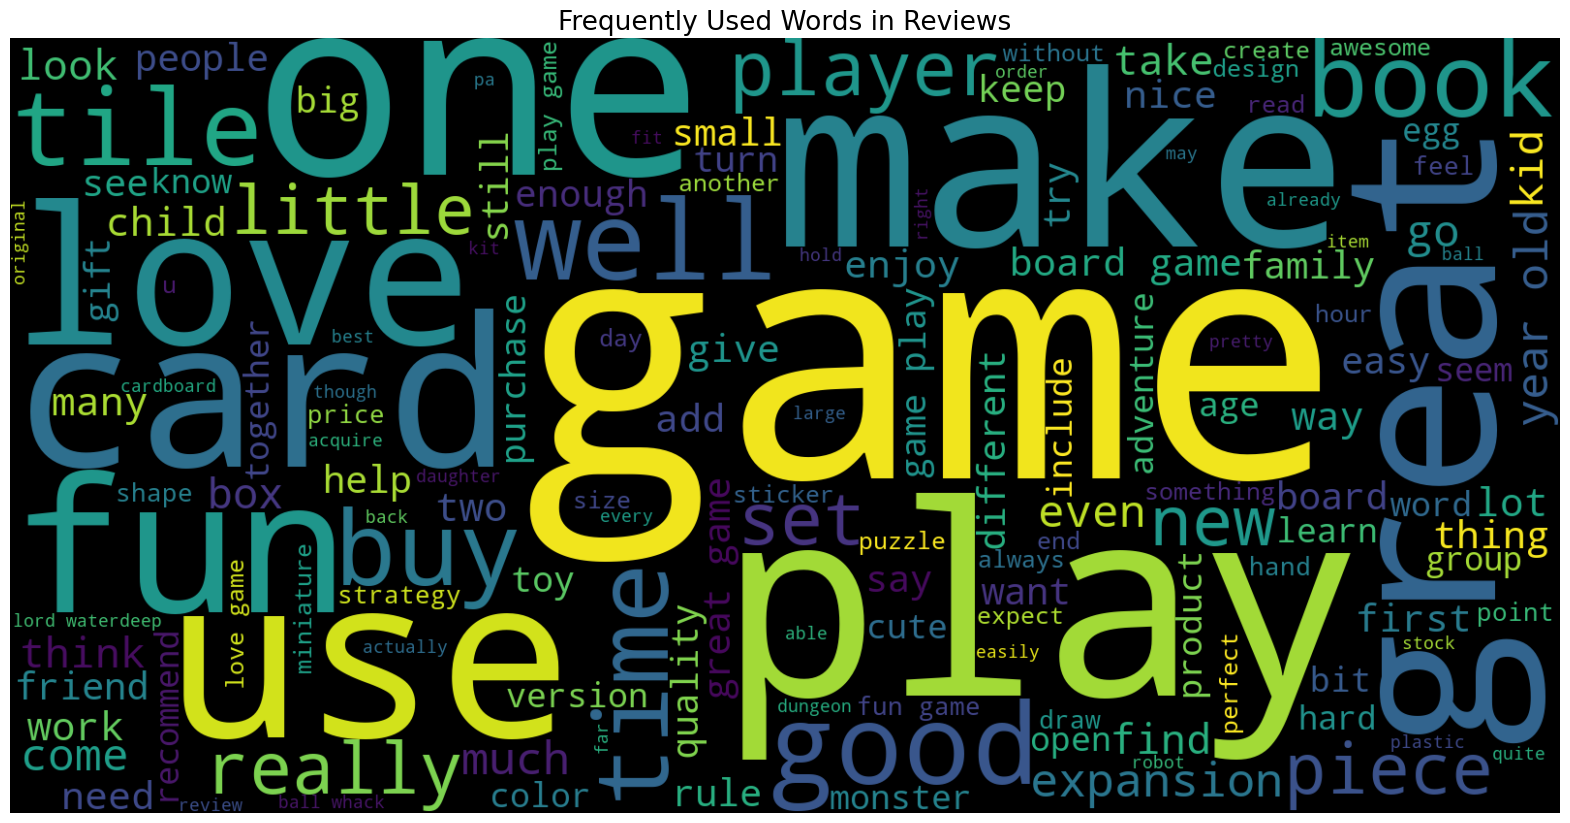

In [130]:
#Plot the wordcloud image for review text 
text = ' '.join([word for word in df_sentiment ['cleaned_review']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=150, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Frequently Used Words in Reviews', fontsize=19)
plt.show()

This is great, we can already draw some meaning from the frequency of common words such as the products7topics most discussed (game,card, tile), and what matter the most,but we need to know their sentiment towards these topics. 

How many of great, love, fun are for example expressing , don't love, not fun, not great? 


In [135]:
# Define Sentiment Intensity Analyser Object (Vader)
sia = SentimentIntensityAnalyzer()

# Set function to calculate polarity 
def analyze_sentiment(text):
    return sia.polarity_scores((text))

# Call the function and calculate the polarity by row for review and summary text 
df_sentiment['sentiment_scores_review'] = df_sentiment['cleaned_review'].apply(analyze_sentiment)
df_sentiment['sentiment_scores_summary'] = df_sentiment['cleaned_summary'].apply(analyze_sentiment)


# View df
df_sentiment.head()

review  \
0  When it comes to a DM's screen, the space on t...   
1  An Open Letter to GaleForce9*:\n\nYour unpaint...   
2  Nice art, nice printing.  Why two panels are f...   
3  Amazing buy! Bought it as a gift for our new d...   
4  As my review of GF9's previous screens these w...   

                                             summary       marketing_labels  \
0  The fact that 50% of this space is wasted on a...      Cautious Shoppers   
1  Another worthless Dungeon Master's screen from...  Aspirational Spenders   
2                    pretty, but also pretty useless      Cautious Shoppers   
3                                         Five Stars  Aspirational Spenders   
4                                         Money trap      Cautious Shoppers   

   product  age education  gender  \
0      453   18  graduate    Male   
1      466   23  graduate    Male   
2      254   22  graduate  Female   
3      263   25  graduate  Female   
4      291   33  graduate  Female   

                                      cleaned_review  \
0  come dm screen space screen absolute premium f...   
1  open letter galeforce9 unpainted miniature not...   
2  nice nice printing two panel fill general forg...   
3                  amaze buy buy gift new dm perfect   
4  review gf9 previous screen completely unnecess...   

                                     cleaned_summary  \
0  fact 50 space waste not terribly informative need   
1   another wohless dungeon master screen galeforce9   
2                         pretty also pretty useless   
3                                          five star   
4                                         money trap   

                             sentiment_scores_review  \
0  {'neg': 0.232, 'neu': 0.661, 'pos': 0.107, 'co...   
1  {'neg': 0.193, 'neu': 0.529, 'pos': 0.278, 'co...   
2  {'neg': 0.208, 'neu': 0.573, 'pos': 0.219, 'co...   
3  {'neg': 0.0, 'neu': 0.284, 'pos': 0.716, 'comp...   
4  {'neg': 0.37, 'neu': 0.63, 'pos': 0.0, 'compou...   

                            sentiment_scores_summary  
0  {'neg': 0.239, 'neu': 0.512, 'pos': 0.249, 'co...  
1  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  
2  {'neg': 0.275, 'neu': 0.098, 'pos': 0.627, 'co...  
3  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  
4  {'neg': 0.697, 'neu': 0.303, 'pos': 0.0, 'comp...

In [148]:
# Extract individual sentiment scores for review text
df_sentiment['neg_review_vader'] = df_sentiment['sentiment_scores_review'].apply(lambda x: x['neg'])
df_sentiment['neu_review_vader'] = df_sentiment['sentiment_scores_review'].apply(lambda x: x['neu'])
df_sentiment['pos_review_vader'] = df_sentiment['sentiment_scores_review'].apply(lambda x: x['pos'])
df_sentiment['compound_review_vader'] = df_sentiment['sentiment_scores_review'].apply(lambda x: x['compound'])

# Extract individual sentiment scores for summary text
df_sentiment['neg_summary_vader'] = df_sentiment['sentiment_scores_summary'].apply(lambda x: x['neg'])
df_sentiment['neu_summary_vader'] = df_sentiment['sentiment_scores_summary'].apply(lambda x: x['neu'])
df_sentiment['pos_summary_vader'] = df_sentiment['sentiment_scores_summary'].apply(lambda x: x['pos'])
df_sentiment['compound_summary_vader'] = df_sentiment['sentiment_scores_summary'].apply(lambda x: x['compound'])

# Create a copy of df_sentiment
df_sentiment_updated = df_sentiment.copy()

# Drop unnecessary columns
columns_to_drop = ['sentiment_scores_review', 'sentiment_scores_summary']
df_sentiment_updated.drop(columns=columns_to_drop, inplace=True)

# Determine overall sentiment based on compound scores
def get_sentiment_label(compound):
    if compound >= 0.05:
        return 'Positive'
    elif compound <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment labeling functions to create new columns
df_sentiment_updated['vader_sentiment_review'] = df_sentiment_updated['compound_review_vader'].apply(get_sentiment_label)
df_sentiment_updated['vader_sentiment_summary'] = df_sentiment_updated['compound_summary_vader'].apply(get_sentiment_label)

# Display the updated DataFrame
df_sentiment_updated.head()

review  \
0  When it comes to a DM's screen, the space on t...   
1  An Open Letter to GaleForce9*:\n\nYour unpaint...   
2  Nice art, nice printing.  Why two panels are f...   
3  Amazing buy! Bought it as a gift for our new d...   
4  As my review of GF9's previous screens these w...   

                                             summary       marketing_labels  \
0  The fact that 50% of this space is wasted on a...      Cautious Shoppers   
1  Another worthless Dungeon Master's screen from...  Aspirational Spenders   
2                    pretty, but also pretty useless      Cautious Shoppers   
3                                         Five Stars  Aspirational Spenders   
4                                         Money trap      Cautious Shoppers   

   product  age education  gender  \
0      453   18  graduate    Male   
1      466   23  graduate    Male   
2      254   22  graduate  Female   
3      263   25  graduate  Female   
4      291   33  graduate  Female   

                                      cleaned_review  \
0  come dm screen space screen absolute premium f...   
1  open letter galeforce9 unpainted miniature not...   
2  nice nice printing two panel fill general forg...   
3                  amaze buy buy gift new dm perfect   
4  review gf9 previous screen completely unnecess...   

                                     cleaned_summary  neg_review_vader  \
0  fact 50 space waste not terribly informative need             0.232   
1   another wohless dungeon master screen galeforce9             0.193   
2                         pretty also pretty useless             0.208   
3                                          five star             0.000   
4                                         money trap             0.370   

   neu_review_vader  pos_review_vader  compound_review_vader  \
0             0.661             0.107                -0.7067   
1             0.529             0.278                 0.8679   
2             0.573             0.219                -0.2310   
3             0.284             0.716                 0.8779   
4             0.630             0.000                -0.7063   

   neg_summary_vader  neu_summary_vader  pos_summary_vader  \
0              0.239              0.512              0.249   
1              0.000              1.000              0.000   
2              0.275              0.098              0.627   
3              0.000              1.000              0.000   
4              0.697              0.303              0.000   

   compound_summary_vader vader_sentiment_review vader_sentiment_summary  
0                  0.0320               Negative                 Neutral  
1                  0.0000               Positive                 Neutral  
2                  0.5574               Negative                Positive  
3                  0.0000               Positive                 Neutral  
4                 -0.3182               Negative                Negative

**Visualise Sentiment - Review vs Summary**

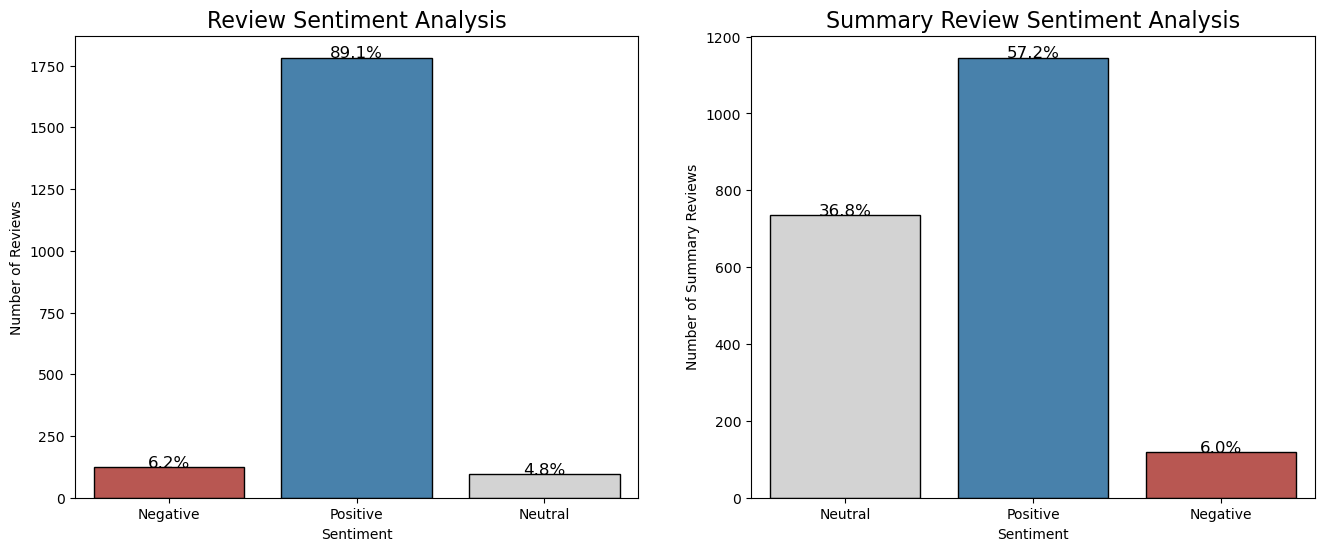

In [149]:
# Set the figure size and create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Define color palette 
palette = {'Negative': '#c94741', 'Positive': '#3783bb', 'Neutral': '#D3D3D3'}

# Create Countplot to display review sentiment
sns.countplot(x='vader_sentiment_review', data=df_sentiment_updated, palette=palette, ax=ax1, edgecolor='black')

# Set title and labels for ax1
ax1.set_title('Review Sentiment Analysis', fontsize=16)
ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Number of Reviews')

# Annotate countplot for ax1
total_reviews = len(df_sentiment_updated['vader_sentiment_review'])
for p in ax1.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_reviews)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax1.annotate(percentage, (x, y), ha='center', fontsize=12)

# Create Countplot to display summary review sentiment
sns.countplot(x='vader_sentiment_summary', data=df_sentiment_updated, palette=palette, ax=ax2, edgecolor='black')

# Set title and labels for ax2
ax2.set_title('Summary Review Sentiment Analysis', fontsize=16)
ax2.set_xlabel('Sentiment')
ax2.set_ylabel('Number of Summary Reviews')

# Annotate countplot for ax2
total_summary_reviews = len(df_sentiment_updated['vader_sentiment_summary'])
for p in ax2.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_summary_reviews)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax2.annotate(percentage, (x, y), ha='center', fontsize=12)

plt.show()

The VADER sentiment analysis of summary reviews detected a higher proportion of neutral sentiment compared to the analysis of whole reviews. 
This discrepancy may be due to the condensed nature of summary reviews, which might lead to a more balanced or less emotional tone, while whole reviews contain more detailed and emotive content, resulting in a stronger positive sentiment. 

**Accuracy Check - Review Text Vs Summmary**

In [150]:
# Create Subset 
df_vader = df_sentiment_updated[['review', 'summary','vader_sentiment_review', 'vader_sentiment_summary']]

# Sample of random text to veryfy reliability fo
sample_df_vader = df_vader.sample(n=20,random_state = 42)
sample_df_vader

review  \
1860  A fun game if you like Scrabble and other word...   
353   My almost 9 Year Old loves this pom-pom puppy ...   
1333  Makes an awesome game even better, and opens u...   
905   This game was a little fun...not super fantast...   
1289  Or you might REALLY LOVE IT...\nSome of my fri...   
1273  If you want something other than a large battl...   
938   My husband bought this so we as a family could...   
1731  Bought this for my daughter she said its lots ...   
65                                           Very Cute!   
1323  If you love Lords of Waterdeep, you will proba...   
56    Sometimes you need something new and special t...   
1292  My wife and I LOVE this game.  While she was r...   
1118  I've only played full D&D adventures a few tim...   
584   We purchased the Star From Afar few years ago,...   
374   As a therapist who plays a lot of UNO with chi...   
275                     Recipient 11 yrs. old loves it!   
746   This is 54 cards; 6 shapes by 9 different colo...   
128   love this little book for an extra little fun ...   
1646  On David Rothmans 12th birthday he was a virtu...   
1852                                          good size   

                                                summary  \
1860  A fun game if you like Scrabble and other word...   
353                      My almost 9 Year Old Loves it!   
1333                                         Five Stars   
905                                       Mediocre Game   
1289            If you like RPG/D&D You might love this   
1273                         A good first start for DMs   
938                                    Great purchase!!   
1731                                  Overall great toy   
65                                           Very Cute!   
1323                 Everything an expansion should be!   
56                                  Great 30 minute toy   
1292                  Best game I've played in a while!   
1118                                           fun game   
584   The hardcover book is beautifully written in r...   
374      Good quality.  Use frequently in plat therapy.   
275                                          Five Stars   
746   Wasn't what I was hoping for, but turned out o...   
128                                     fun cheap silly   
1646  A survival guide for young people who are hear...   
1852                                         Five Stars   

     vader_sentiment_review vader_sentiment_summary  
1860               Positive                Positive  
353                Positive                Positive  
1333               Positive                 Neutral  
905                Positive                 Neutral  
1289               Positive                Positive  
1273               Positive                Positive  
938                Positive                Positive  
1731               Positive                Positive  
65                 Positive                Positive  
1323               Positive                 Neutral  
56                 Positive                Positive  
1292               Positive                Positive  
1118               Positive                Positive  
584                Positive                Positive  
374                Positive                Positive  
275                Positive                 Neutral  
746                Positive                Negative  
128                Positive                Positive  
1646               Negative                 Neutral  
1852               Positive                 Neutral

In [151]:
# check closer review ,1333,905, 1323, 275,1646, 1852, 746 where sentiment are in dissonance
print(sample_df_vader['review'][1333])
print(sample_df_vader['review'][905])
print(sample_df_vader['review'][1323])
print(sample_df_vader['review'][275])
print(sample_df_vader['review'][1646])
print(sample_df_vader['review'][1852])
print(sample_df_vader['review'][746])


Makes an awesome game even better, and opens up more space for a sixth player to join in.
This game was a little fun...not super fantastic although my husband enjoys it a lot more than I do. A few things are different from the original like colors and the names of the hotel chains. A great game for someone who is very detail oriented.
If you love Lords of Waterdeep, you will probably love this expansion.  Lords of Waterdeep is easily in my top 5 favorite games.  The base game plays very well and I will happily play it once or twice a week and don't get tired of it.  In other words - you don't *need* this expansion to enjoy the base game.  (Which bodes well for the game, but not necessarily the expansion.)

So why did I get the expansion?  I mainly got this because I wanted to add in the option to play with a 6th player.  When my sister and her sons come over to play, we're sometimes in the 6 player range and it's unfortunate to make anyone sit out.  Scoundrels of Skullport adds a 6th p

- Vader Summary Reviews struggle to detect five-star ratings as positive comments, while wrongly labeling row 1852 as neutral.     This suggests that neutral summary comments might be overrepresented.

- Row 1646 is mislabeled in both cases. It includes nuanced opinions, but overall, the sentiment sounds positive.

- Row 746 and 905 could be interpreted as positive for the brand, but not what the customer was hoping for, indicating       subjectivity rather than a product issue. In this case, Vader successfully labels the whole review as positive.

**Since we are interested in understanding customer sentiment with detailed feedback, we will consider only whole reviews**

Accuracy based on random sample of 20 whole reviews is overall high. 

**Given the size of the df(2000 entries) and subjectivity not detected by Vader arised from the sampled reviews, we will compare accuracy with TextBlob, which better handle subjective language and nuanced opinions compared to the Vader's lexicon-based approach.**


## Compare Model with TextBlob 

In [152]:
def polarity(text):
    '''Extract polarity score (-1 to +1) and subjectivity (0 to 1) for each comment'''
    analysis = TextBlob(text).sentiment
    polarity_score = analysis.polarity
    subjectivity_score = analysis.subjectivity
    return polarity_score, subjectivity_score

In [153]:
# Define function to calculate polarity with TEXT
def polarity(text):
    '''Extract polarity and subjectivity score (-1 to +1) for each comment'''
    analysis = TextBlob(text).sentiment
    polarity_score = analysis.polarity
    subjectivity_score = analysis.subjectivity
    return polarity_score, subjectivity_score

# Call the function and create two columns with polarity and subjectivity data. 
df_sentiment_updated[['review_polarity', 'review_subjectivity']] = df_sentiment_updated['cleaned_review']\
.apply(polarity).apply(pd.Series)

df_sentiment_updated.head()

review  \
0  When it comes to a DM's screen, the space on t...   
1  An Open Letter to GaleForce9*:\n\nYour unpaint...   
2  Nice art, nice printing.  Why two panels are f...   
3  Amazing buy! Bought it as a gift for our new d...   
4  As my review of GF9's previous screens these w...   

                                             summary       marketing_labels  \
0  The fact that 50% of this space is wasted on a...      Cautious Shoppers   
1  Another worthless Dungeon Master's screen from...  Aspirational Spenders   
2                    pretty, but also pretty useless      Cautious Shoppers   
3                                         Five Stars  Aspirational Spenders   
4                                         Money trap      Cautious Shoppers   

   product  age education  gender  \
0      453   18  graduate    Male   
1      466   23  graduate    Male   
2      254   22  graduate  Female   
3      263   25  graduate  Female   
4      291   33  graduate  Female   

                                      cleaned_review  \
0  come dm screen space screen absolute premium f...   
1  open letter galeforce9 unpainted miniature not...   
2  nice nice printing two panel fill general forg...   
3                  amaze buy buy gift new dm perfect   
4  review gf9 previous screen completely unnecess...   

                                     cleaned_summary  neg_review_vader  ...  \
0  fact 50 space waste not terribly informative need             0.232  ...   
1   another wohless dungeon master screen galeforce9             0.193  ...   
2                         pretty also pretty useless             0.208  ...   
3                                          five star             0.000  ...   
4                                         money trap             0.370  ...   

   pos_review_vader  compound_review_vader  neg_summary_vader  \
0             0.107                -0.7067              0.239   
1             0.278                 0.8679              0.000   
2             0.219                -0.2310              0.275   
3             0.716                 0.8779              0.000   
4             0.000                -0.7063              0.697   

   neu_summary_vader  pos_summary_vader  compound_summary_vader  \
0              0.512              0.249                  0.0320   
1              1.000              0.000                  0.0000   
2              0.098              0.627                  0.5574   
3              1.000              0.000                  0.0000   
4              0.303              0.000                 -0.3182   

   vader_sentiment_review vader_sentiment_summary review_polarity  \
0                Negative                 Neutral       -0.028571   
1                Positive                 Neutral        0.016792   
2                Negative                Positive        0.117369   
3                Positive                 Neutral        0.568182   
4                Negative                Negative       -0.316667   

   review_subjectivity  
0             0.428571  
1             0.441291  
2             0.428197  
3             0.727273  
4             0.316667  

[5 rows x 21 columns]

In [154]:
# Categorise polarity score
def get_blob_sentiment(score):
    if score > 0:
        return 'Positive'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Negative'
    
df_sentiment_updated['sentiment_labels_blob']= df_sentiment_updated['review_polarity'].apply(get_blob_sentiment)


# Categorise subjectivity score 
def get_subjectivity(subjectivity_score):
    if subjectivity_score <= 0.3:
        return 'Low Subjectivity'
    elif subjectivity_score > 0.3 and subjectivity_score <= 0.7:
        return 'Moderate Subjectivity'
    else:
        return 'High Subjectivity'

    
# Call the functions to obtain polarity and subjectivy score category columns
df_sentiment_updated['sentiment_labels_blob']= df_sentiment_updated['review_polarity'].apply(get_blob_sentiment)
df_sentiment_updated['subjectivity_labels_blob']= df_sentiment_updated['review_subjectivity'].apply(get_blob_sentiment)

df_sentiment_updated.head()


review  \
0  When it comes to a DM's screen, the space on t...   
1  An Open Letter to GaleForce9*:\n\nYour unpaint...   
2  Nice art, nice printing.  Why two panels are f...   
3  Amazing buy! Bought it as a gift for our new d...   
4  As my review of GF9's previous screens these w...   

                                             summary       marketing_labels  \
0  The fact that 50% of this space is wasted on a...      Cautious Shoppers   
1  Another worthless Dungeon Master's screen from...  Aspirational Spenders   
2                    pretty, but also pretty useless      Cautious Shoppers   
3                                         Five Stars  Aspirational Spenders   
4                                         Money trap      Cautious Shoppers   

   product  age education  gender  \
0      453   18  graduate    Male   
1      466   23  graduate    Male   
2      254   22  graduate  Female   
3      263   25  graduate  Female   
4      291   33  graduate  Female   

                                      cleaned_review  \
0  come dm screen space screen absolute premium f...   
1  open letter galeforce9 unpainted miniature not...   
2  nice nice printing two panel fill general forg...   
3                  amaze buy buy gift new dm perfect   
4  review gf9 previous screen completely unnecess...   

                                     cleaned_summary  neg_review_vader  ...  \
0  fact 50 space waste not terribly informative need             0.232  ...   
1   another wohless dungeon master screen galeforce9             0.193  ...   
2                         pretty also pretty useless             0.208  ...   
3                                          five star             0.000  ...   
4                                         money trap             0.370  ...   

   neg_summary_vader  neu_summary_vader  pos_summary_vader  \
0              0.239              0.512              0.249   
1              0.000              1.000              0.000   
2              0.275              0.098              0.627   
3              0.000              1.000              0.000   
4              0.697              0.303              0.000   

   compound_summary_vader  vader_sentiment_review  vader_sentiment_summary  \
0                  0.0320                Negative                  Neutral   
1                  0.0000                Positive                  Neutral   
2                  0.5574                Negative                 Positive   
3                  0.0000                Positive                  Neutral   
4                 -0.3182                Negative                 Negative   

   review_polarity review_subjectivity sentiment_labels_blob  \
0        -0.028571            0.428571              Negative   
1         0.016792            0.441291              Positive   
2         0.117369            0.428197              Positive   
3         0.568182            0.727273              Positive   
4        -0.316667            0.316667              Negative   

   subjectivity_labels_blob  
0                  Positive  
1                  Positive  
2                  Positive  
3                  Positive  
4                  Positive  

[5 rows x 23 columns]

**Plot Textblob vs Vader outputs**

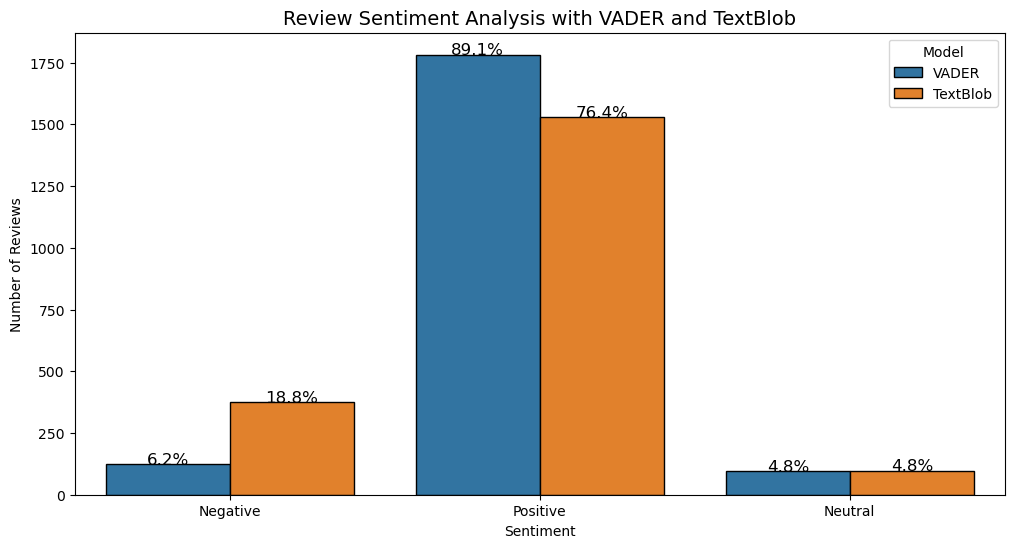

In [155]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Melt the DataFrame to have a single column for sentiments and another for the model type
df_melted = df_sentiment_updated.melt(value_vars=['vader_sentiment_review', 'sentiment_labels_blob'], 
                                      var_name='Model', 
                                      value_name='Sentiment')

# Create a Countplot with hue to display review sentiment
sns.countplot(x='Sentiment', hue='Model', data=df_melted, edgecolor='black')

# Set title and labels
plt.title('Review Sentiment Analysis with VADER and TextBlob', fontsize=14)
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')

# Annotate countplot
for p in plt.gca().patches:
    height = p.get_height()
    model = 'vader_sentiment_review' if 'VADER' in p.get_label() else 'sentiment_labels_blob'
    total_reviews = len(df_melted[df_melted['Model'] == model])
    percentage = '{:.1f}%'.format(100 * height / total_reviews)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    plt.annotate(percentage, (x, y), ha='center', fontsize=12)

plt.legend(title='Model',labels=['VADER', 'TextBlob'])
plt.show()



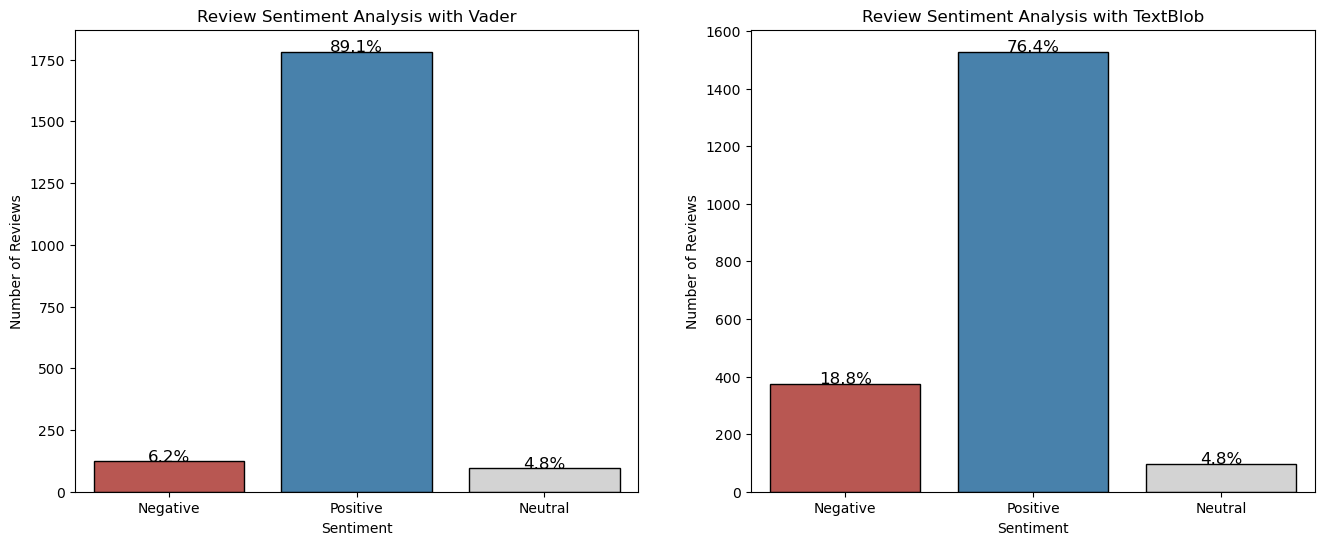

In [156]:
# Set the figure size and create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Create Countplot to display review sentiment
sns.countplot(x='vader_sentiment_review', data=df_sentiment_updated, palette=palette, ax=ax1, edgecolor='black')

# Set title and labels for ax1
ax1.set_title('Review Sentiment Analysis with Vader', fontsize=12)
ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Number of Reviews')

# Annotate countplot for ax1
total_reviews = len(df_sentiment_updated['vader_sentiment_review'])
for p in ax1.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_reviews)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax1.annotate(percentage, (x, y), ha='center', fontsize=12)

# Create Countplot to display summary review sentiment
ax2 = sns.countplot(x='sentiment_labels_blob', data=df_sentiment_updated, palette = palette, edgecolor= 'black')

# Set title and labels for ax2
ax2.set_title('Review Sentiment Analysis with TextBlob', fontsize=12)
ax2.set_xlabel('Sentiment')
ax2.set_ylabel('Number of Reviews')


# Annotate countplot for ax2
total_summary_reviews = len(df_sentiment_updated['sentiment_labels_blob'])
for p in ax2.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_summary_reviews)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax2.annotate(percentage, (x, y), ha='center', fontsize=12)

plt.show()




Compared to Vader, analysis with Textblob individuated higher % of negative sentiments but similar % of neutral reviews. 
Let's check the models accuracy. 

## Check accuracy on random reviews: VADER vs TEXTBlob

In [157]:
# Create subset with column needed 
df_accuracy_test = df_sentiment_updated[['review','vader_sentiment_review','compound_review_vader','review_polarity','review_subjectivity','sentiment_labels_blob','subjectivity_labels_blob']]

# Create a sample
df_accuracy_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   review                    2000 non-null   object 
 1   vader_sentiment_review    2000 non-null   object 
 2   compound_review_vader     2000 non-null   float64
 3   review_polarity           2000 non-null   float64
 4   review_subjectivity       2000 non-null   float64
 5   sentiment_labels_blob     2000 non-null   object 
 6   subjectivity_labels_blob  2000 non-null   object 
dtypes: float64(3), object(4)
memory usage: 109.5+ KB


Models accuracy will be checked manually on Excel. Since we are more interested in negative reviews, we will proceed to:
- Select a random sample of reviews for a general accuracy check
- Evaluate the classification performance of negative reviews twice: once based on Vader's negative classified reviews and once based on TextBlob's outputs

In [158]:
# Create the first general sample  
sample_test1 = df_accuracy_test.sample(n= 10, random_state = 32)
sample_test1['labelled_sentiment']= ''

# Transfrom to csv.file
sample_test1.to_excel('sample_test1.xlsx',index=False)

In [159]:
# Filter the subset with negative reviews (vader outputs)
accuracy_test_vad_neg_rev = df_accuracy_test[df_accuracy_test['vader_sentiment_review'] == 'Negative']

# Create sample 
sample_test_neg_rev1 = accuracy_test_vad_neg_rev.sample(n=10, random_state=50)
sample_test_neg_rev1['labelled_sentiment']= ''

# Transfrom to csv.file
sample_test_neg_rev1.to_excel('sample_test_neg_review_vader.xlsx', index=False)


In [160]:
# Filter the subset with negative reviews (TextBlob outputs)
accuracy_test_blob_neg_rev = df_accuracy_test[df_accuracy_test['sentiment_labels_blob'] == 'Negative']

# Create sample 
sample_test_neg_rev2 = accuracy_test_blob_neg_rev.sample(n=10, random_state=25)
sample_test_neg_rev2['labelled_sentiment'] = ''

sample_test_neg_rev2.to_excel('sample_test_neg_review_blob.xlsx',index=False)

From the manual accuracy check we have noticed that for this specific dataset
- TextBlob performed overall better than Vader 
- Vader performed poorly on long test review.
- Language used is often formal which indicate Vader could be not the best model. 

count    2000.00000
mean       28.86600
std        51.76144
min         0.00000
25%         6.00000
50%        14.00000
75%        31.00000
max       757.00000
Name: cleaned_review, dtype: float64


Text(0.5, 1.0, 'Reviews Word Count Distribution')

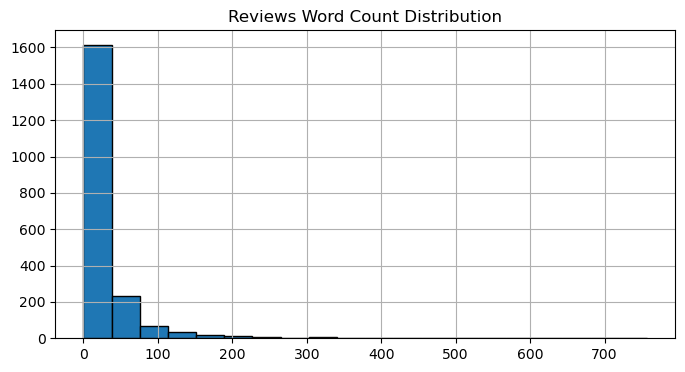

In [161]:
# Calculate number of words in each review
word_count = df_sentiment_updated['cleaned_review'].apply(lambda x: len(x.split()))

# Check distribution and statistical summary
print(word_count.describe())

#Plot distribution
plt.figure(figsize=(8,4))
word_count.hist(bins=20, edgecolor='black')
plt.title('Reviews Word Count Distribution')


There is high variation in review lengths; while 75% of the data has 31 words or less, many reviews are lengthy and include multiple sentiments.

The manual accuracy test and the observations about the lengthiness and sometimes formal language led us to conclude that VADER is not the best model for this dataset.

TextBlob Cons: overrepresent negatives reviews 

**Reccomendations:
- option 1.Bert model could be more appropriate given the capacity of the model to understand context.
- option 2) Apply combination of Vader on short strings and Textblob on lenghty reviews **

Let's have a closer look at the TextBlob polarity score. 

# Plot the Distribution of Polarity and Subjectivity

In [162]:
# Summary of polarity score 
df_sentiment_updated['review_polarity'].describe()

count    2000.000000
mean        0.199569
std         0.260752
min        -0.700000
25%         0.015329
50%         0.162500
75%         0.350000
max         1.000000
Name: review_polarity, dtype: float64

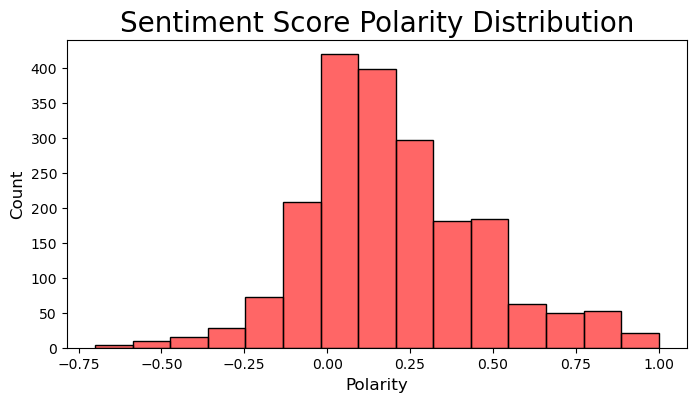

In [163]:
# Set the number of bins.
num_bins = 15

# Set the plot area.
plt.figure(figsize=(8,4))

# Define the bars.
sns.histplot(df_sentiment_updated['review_polarity'], bins=num_bins, color='red', alpha=0.6)

# Set the labels.
plt.xlabel('Polarity', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Sentiment Score Polarity Distribution', fontsize=20)

plt.show()

Majority of reviews labelled positive, but negative reviews are more than neutral. 

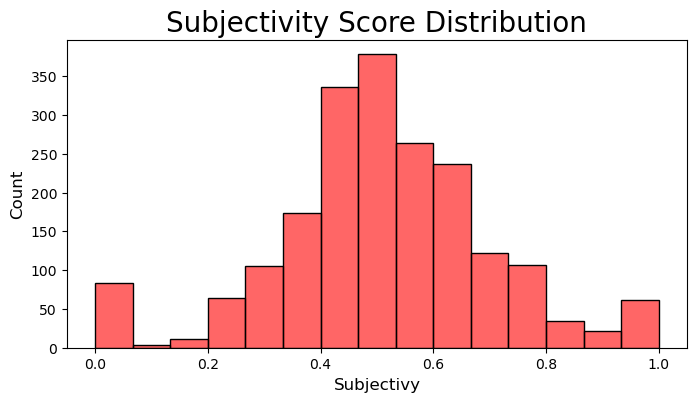

In [164]:
# Set the number of bins.
num_bins = 15

# Set the plot area.
plt.figure(figsize=(8,4))

# Define the bars.
sns.histplot(df_sentiment_updated['review_subjectivity'], bins=num_bins, color='red', alpha=0.6)

# Set the labels.
plt.xlabel('Subjectivy', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Subjectivity Score Distribution', fontsize=20)

plt.show()

Unsurprisingly, only a small minority of reviews are objectives. This is normal,especially when dealing with reviews.

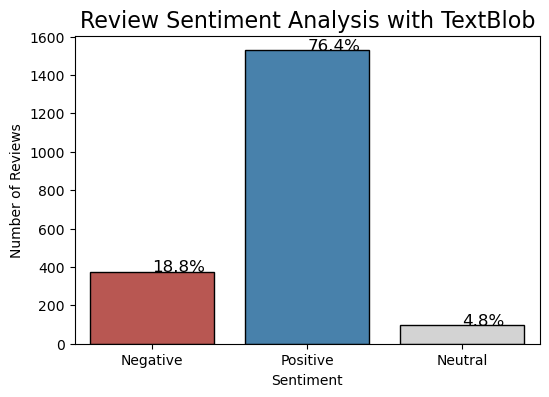

In [165]:
# Create Countplot to display review sentiment with Texblob for stakeholders 
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='sentiment_labels_blob', data=df_sentiment_updated, palette = palette, edgecolor= 'black')

# Set title and labels for ax
ax.set_title('Review Sentiment Analysis with TextBlob', fontsize=16)
ax.set_xlabel('Sentiment')
ax.set_ylabel('Number of Reviews')

total = len(df_sentiment_updated['sentiment_labels_blob'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage,(x,y),fontsize=12)

## Top 20 positive and negative reviews 

**Most Negative Reviews**

In [166]:
#Create df
df_sentiment_final = df_sentiment_updated.copy() 

# Drop unnecessary columns
df_sentiment_final = df_sentiment_updated.drop(['summary', 'neg_review_vader', 'neu_review_vader',
       'pos_review_vader', 'compound_review_vader', 'neg_summary_vader',
       'neu_summary_vader', 'pos_summary_vader', 'compound_summary_vader',
       'vader_sentiment_review', 'vader_sentiment_summary'],axis=1)


# Filter sentiment classification by negative reviews and sort in ascending order
negative_reviews = df_sentiment_final[df_sentiment_final['sentiment_labels_blob'] == 'Negative']
negative_reviews = negative_reviews.sort_values(['review_polarity'], ascending=False)
negative_reviews.tail()


# Extract top 20 negative reviews
top_20_neg_rev= df_sentiment_final.nsmallest(20, 'review_polarity')
# Enlarge cleaned text cell 
top_20_neg_rev.style.set_properties(subset=['review'], **{'width': '1200px'})

A consistent part of top negative reviews are false negatives (Row 364 and 1464 , 427, 803, 813, 845,989, 1359) 

**Visualise Negative Reviews Wordcloud.**

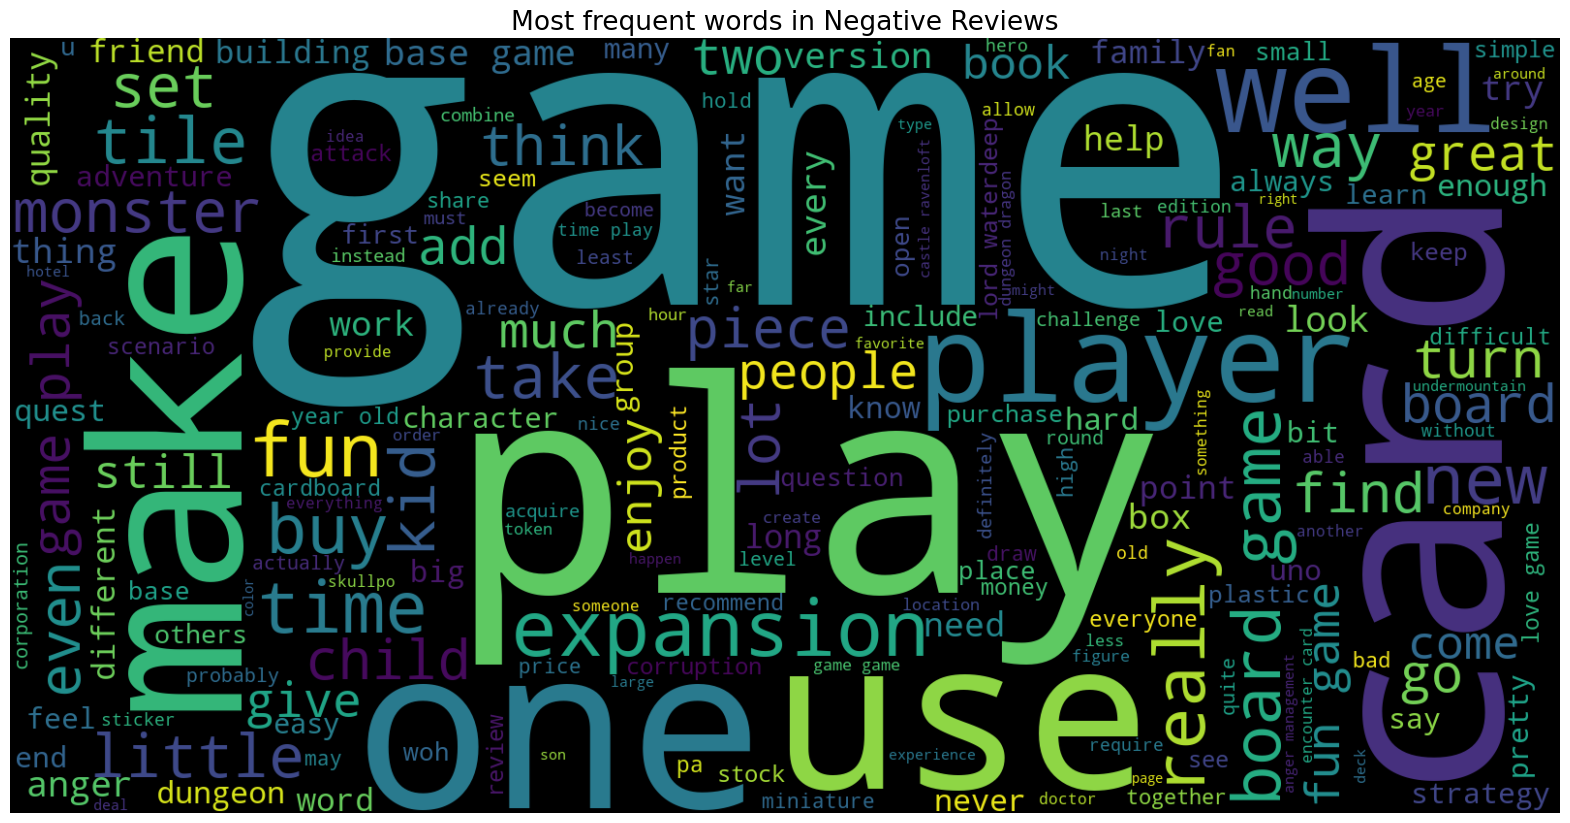

In [167]:
# Create Wordcloud 
text = ' '.join([word for word in negative_reviews['cleaned_review']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words= 200, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in Negative Reviews', fontsize=19)
plt.show()

Based on the analysis, many negative reviews seem to focus on board games, cards, expansions, and the quality and usefulness of the products. While useful for identifying the most discussed topics, word cloud analysis does not provide information about the specific products that are criticized.

## Indentify Proportion of Negative Reviews by Product and Topics 

**Negative reviews in proportion to total review per product**

In [172]:
# Count of reviews per product
reviews_by_product = df_sentiment_final.groupby('product').size().reset_index(name='total_review_count')

# Group negative reviews by products
neg_rev_by_product = negative_reviews.groupby('product').size().reset_index(name='negative_review_count')

# Merge negative reviews and reviews count (left join)
reviews_by_product = pd.merge(neg_rev_by_product, reviews_by_product, on='product')

# Calculate the proportion of negative reviews
reviews_by_product['negative_review_proportion'] = reviews_by_product['negative_review_count'] / reviews_by_product['total_review_count']

# Sort the result by 'negative_review_proportion' in descending order
reviews_by_product.sort_values(by='negative_review_proportion', ascending=False).head(10)

product  negative_review_count  total_review_count  \
101     4399                      6                  10   
63      2795                      6                  10   
116     5512                      5                  10   
68      2870                      5                  10   
10       486                      5                  10   
159     9597                      5                  10   
44      1945                      4                  10   
45      1970                      4                  10   
37      1501                      4                  10   
147     8275                      4                  10   

     negative_review_proportion  
101                         0.6  
63                          0.6  
116                         0.5  
68                          0.5  
10                          0.5  
159                         0.5  
44                          0.4  
45                          0.4  
37                          0.4  
147                         0.4

We have overall 10 reviews by product. On this basis, having 30 or 40 % of true negative reviews per a product is a high risk for the business that can impact brand reputation, customer satisfaction and flag import insight for product improvement.  

Here we will look at the first two items of this list of negative reviews to evaluates the potential usefulness of this approach. 

In [173]:
# Check product 2795
reviews_prod_2795 = negative_reviews[negative_reviews['product'] == 2795][['product', 'review']]

reviews_prod_2795.style.set_properties(subset=['review'], **{'width': '1200px'})

In [174]:
# Check product 486
reviews_prod_486 = negative_reviews[negative_reviews['product'] == 486][['product', 'review']]

reviews_prod_486.style.set_properties(subset=['review'], **{'width': '1200px'})

**While there are 3 false negative reviews, 3 reviews on Product 2795 highlight quality and cost issues.**
**On product 486, there are 2 false negative, but 3 out of 10 reviews commented the product to be boring** 

These information can serve guide marketing strategies and product development.

Manual check however can be time consuming, is there a way to automate this process a bit more? 
Let's explore Spacy!

In [178]:
import spacy
from spacy.matcher import Matcher

# Load the SpaCy model (ensure it's installed)
nlp = spacy.load("en_core_web_sm")

#Function to extract adjectives from a list of reviews
def extract_adjectives(reviews):
    '''this function use Spacy Matcher class to extract adjectives from text '''
    # Initialise the Matcher 
    matcher = Matcher(nlp.vocab)
    #Define Pattern to match (adjective, but you can add different POS)
    pattern= [{'POS': 'ADJ'}]
    
    matcher.add("AdjectivePattern", [pattern])

    adjectives = []
    for review in reviews:
        doc = nlp(review)
        matches = matcher(doc)
        for match_id, start, end in matches:
            span = doc[start:end]
            adjectives.append(span.text)
    return adjectives

# Extract adjectives from cleaned negative reviews
negative_adjectives = extract_adjectives(negative_reviews['cleaned_summary'])
    
adjectives_with_product_id = []
for product_id, review in zip(negative_reviews['product'], negative_reviews['cleaned_review']):
    doc = nlp(review)
    adjectives = [token.text for token in doc if token.text in negative_adjectives and token.pos_ == "ADJ"]
    for adj in adjectives:
        adjectives_with_product_id.append((product_id, adj))

# Analyze adjectives by product ID
adjectives_df = pd.DataFrame(adjectives_with_product_id, columns=['product', 'adjective'])

# Group by product ID and count adjectives
adj_from_neg_reviews = adjectives_df.groupby('product')['adjective'].value_counts().reset_index()



In [179]:
# Group by product ID and count adjectives
adjective_counts = adjectives_df.groupby('product')['adjective'].value_counts().reset_index()

# Filter by product
prod_107 = adjective_counts[adjective_counts['product']== 2795]

# View adjective
prod_107


product  adjective  count
288     2795  different      2
289     2795       many      2
290     2795      young      1
291     2795       best      1
292     2795  difficult      1
293     2795    helpful      1
294     2795       much      1
295     2795        old      1
296     2795       open      1
297     2795       poor      1

In [180]:
# Top 20 positive reviews.
# Filter sentiment classification by positive reviews and sort in ascending order
positive_reviews = df_sentiment_final[df_sentiment_final['sentiment_labels_blob'] == 'Positive']
positive_reviews = positive_reviews.sort_values(['review_polarity'], ascending=False)

# Extract top 20 positive reviews
top_20_pos_rev= df_sentiment_final.nlargest(20, 'review_polarity')

# Enlarge cleaned text cell 
top_20_pos_rev.style.set_properties(subset=['cleaned_review'], **{'width': '1200px'})


**Wordcloud analysis**

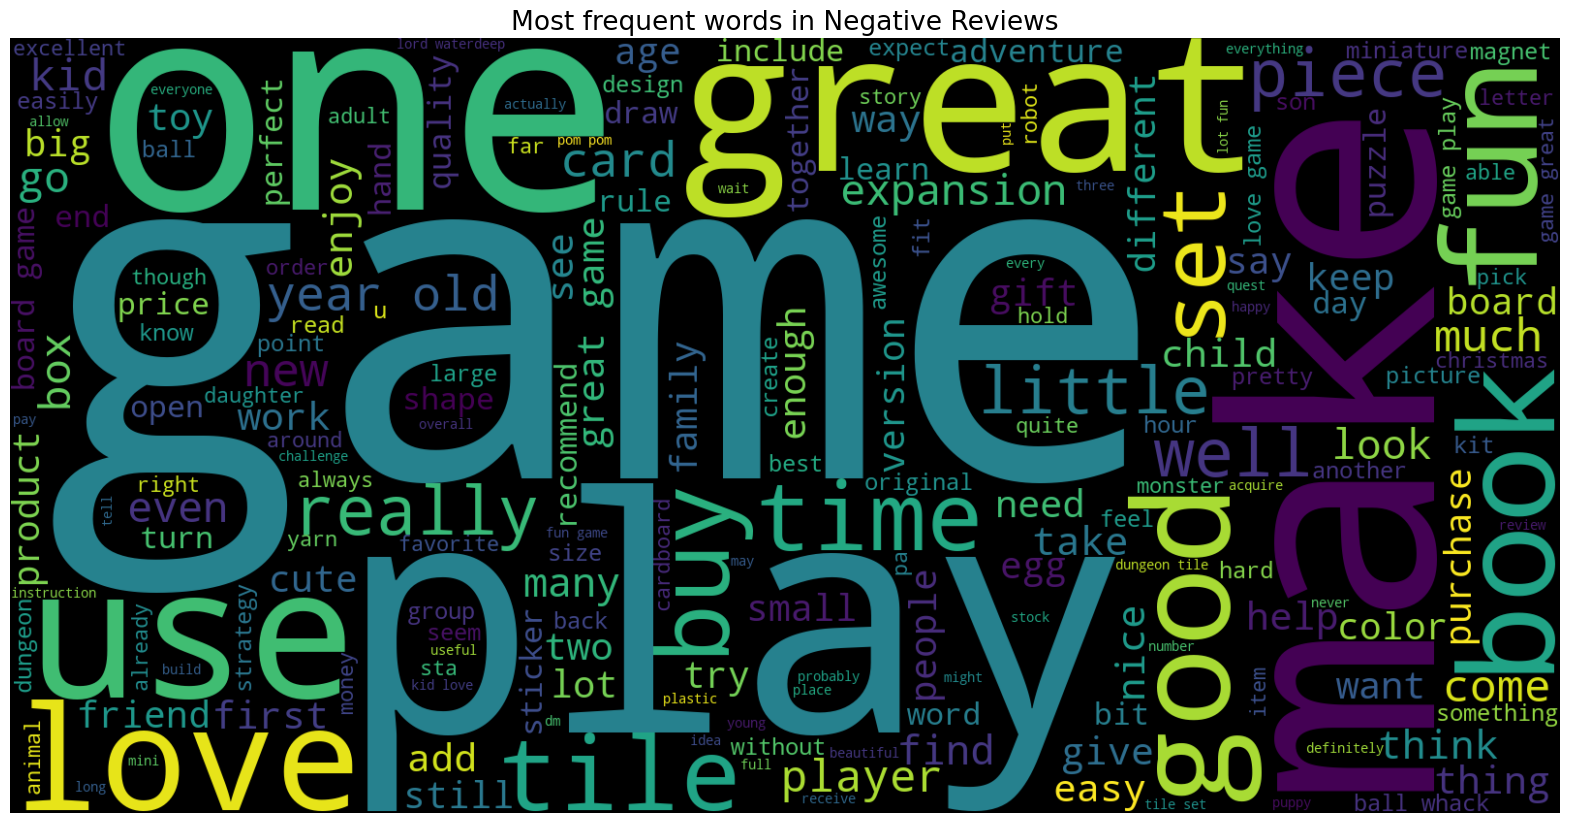

In [181]:
# Create Wordcloud 
text = ' '.join([word for word in positive_reviews['cleaned_review']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words= 200, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in Negative Reviews', fontsize=19)
plt.show()

Here we can apply the same observations as drawn from the negative reviews word cloud. While it reveals positive words and appreciations, it's essential to determine which specific product they refer to.

In [182]:
## Indentify Proportion of Positive Reviews by Product 

In [183]:
# Group negative reviews by products
pos_rev_by_product = positive_reviews.groupby('product').size().reset_index(name='positive_review_count')

# Merge negative reviews and reviews count (left join)
pos_reviews_by_product = pd.merge(pos_rev_by_product, reviews_by_product, on='product')

# Calculate the proportion of negative reviews
pos_reviews_by_product['positive_review_proportion'] = pos_reviews_by_product['positive_review_count'] / reviews_by_product['total_review_count']

# Sort the result by 'negative_review_proportion' in descending order
pos_reviews_by_product.sort_values(by='positive_review_proportion', ascending=False).head(10)

product  positive_review_count  negative_review_count  \
54      2286                      9                      1   
155     9529                      9                      1   
29      1175                      9                      1   
39      1577                      9                      1   
141     7373                      9                      1   
58      2404                      9                      1   
59      2495                      9                      1   
61      2521                      9                      1   
133     6715                      9                      1   
129     6507                      9                      1   

     total_review_count  negative_review_proportion  \
54                   10                         0.1   
155                  10                         0.1   
29                   10                         0.1   
39                   10                         0.1   
141                  10                         0.1   
58                   10                         0.1   
59                   10                         0.1   
61                   10                         0.1   
133                  10                         0.1   
129                  10                         0.1   

     positive_review_proportion  
54                          0.9  
155                         0.9  
29                          0.9  
39                          0.9  
141                         0.9  
58                          0.9  
59                          0.9  
61                          0.9  
133                         0.9  
129                         0.9

In [184]:
# Check product 2162
reviews_prod_2162 = positive_reviews[positive_reviews['product'] == 2162][['product', 'review']]

# enlarge cell 
reviews_prod_2162.style.set_properties(subset=['review'], **{'width': '1200px'})

## Distribution of  Sentiment Reviews by Marketing Groups 

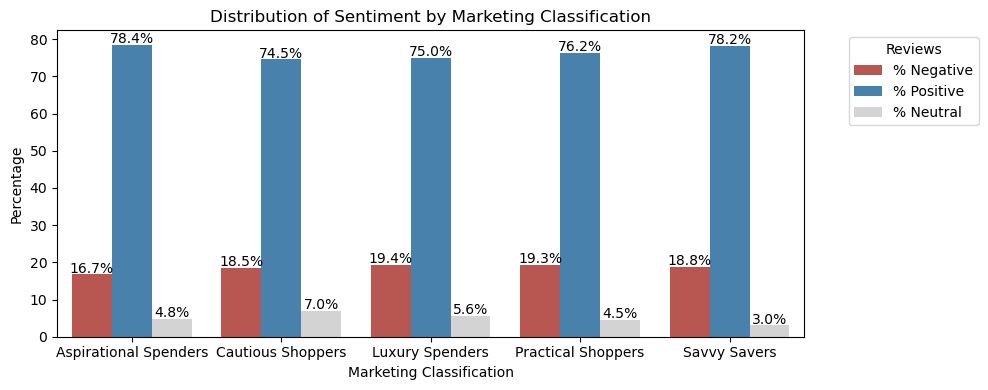

In [185]:
# Group by marketing_labels and sentiment_labels_blob, then calculate counts
marketing_sentiment = df_sentiment_final.groupby(['marketing_labels', 'sentiment_labels_blob']).size().reset_index(name='count')

# Pivot to calculate total reviews by marketing class and to calculate percentages
marketing_sentiment_pivot = pd.pivot_table(marketing_sentiment, 
                                           values='count', 
                                           index='marketing_labels', 
                                           columns='sentiment_labels_blob', 
                                           aggfunc='sum', 
                                           fill_value=0)

#Get the total reviews by row 
marketing_sentiment_pivot['Total'] = marketing_sentiment_pivot.sum(axis=1)
# Calculate % 
marketing_sentiment_pivot['% Negative'] = (marketing_sentiment_pivot['Negative'] / marketing_sentiment_pivot['Total']) * 100
marketing_sentiment_pivot['% Positive'] = (marketing_sentiment_pivot['Positive'] / marketing_sentiment_pivot['Total']) * 100
marketing_sentiment_pivot['% Neutral'] = (marketing_sentiment_pivot['Neutral'] / marketing_sentiment_pivot['Total']) * 100

# Reset index to make 'marketing_labels' a column
marketing_sentiment_pivot.reset_index(inplace=True)

# Melt the DataFrame for plotting
melted_df = pd.melt(marketing_sentiment_pivot, 
                    id_vars='marketing_labels', 
                    value_vars=['% Negative', '% Positive', '% Neutral'], 
                    var_name='sentiment_labels_blob', 
                    value_name='percentage')

# Define colour palette 
palette_2 = {'% Negative': '#c94741', '% Positive': '#3783bb', '% Neutral': '#D3D3D3'}

# Plotting
plt.figure(figsize=(10, 4))
ax = sns.barplot(data=melted_df, x='marketing_labels', y='percentage', hue='sentiment_labels_blob', palette=palette_2)

# Add percentages on top of the bars
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.,
        height + 0.5,
        f'{height:.1f}%',
        ha='center')

# Place the legend outside the plot
plt.legend(title='Reviews', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Distribution of Sentiment by Marketing Classification')
plt.xlabel('Marketing Classification')
plt.ylabel('Percentage')
plt.tight_layout()
plt.show()


high % of positive reviews are consistent across al groups with aspirational spenders and savvy savers among the most satisfied. This is a good sign since positive reviews and testimonials from satisfied customers can be highlighted to attract new customers and retain existing ones.

**Luxory spenders present high % of negative reviews, this group might be more critical or present higher expectation. It's crucial to target them specifically and ensure their satisfaction.**

## Insights and observations STEP 4.


Our preliminary Sentiment Analaysis has focused primarily on negative reviews. 

Vader performed poorly on this dataset given the presence of wordy reviews and double sentimenes. 
Despite the risk of overrepresentation, we decided to adop TextBlob since our goal is to monitor all potential negative sentiments. 

Although these need to be handled with caution, we found a high percentage of positive sentiments toward TG. Negative reviews accounted for about 18%, and since these can influence purchasing decisions and brand reputation, they need to be monitored over time.

Luxory spenders present high % of negative reviews, this group might be more critical or present higher expectation. It's crucial to target them specifically and ensure their satisfaction.

- Product issues: we will provide a list of products with highest frequencies of negative reviews to the marketing and product development department. From our analysis, product 2795 and 486 resulted respectively of poor quality and boring. 
Marketing can use this insight to emphasize improved quality in future campaigns and conduct focus groups to better understand what features/aspects are missing 
This analysis will need to be expanded and looked carefully in future. 

# 

<div style="background-color:#4E8A57; color:white; padding:20px; text-align:center; font-weight:bold; border-radius: 8px; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);">

<h2 style="font-size: 24px;">End of Analysis</h2>
    
</div>